In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import urllib.request
import zipfile
from tqdm import tqdm

# Create directories
os.makedirs("data/raw_midi", exist_ok=True)
os.makedirs("data/abc_notation", exist_ok=True)

# Download clean MIDI subset (this is a smaller sample)
url = "http://hog.ee.columbia.edu/craffel/lmd/clean_midi.tar.gz"
output_file = "clean_midi.tar.gz"

# Download with progress bar
urllib.request.urlretrieve(url, output_file)
print("Downloaded MIDI dataset")

Downloaded MIDI dataset


In [3]:
# Extract
!tar -xzf clean_midi.tar.gz -C data/raw_midi

In [4]:
# Count files
midi_files = []
for root, dirs, files in os.walk("data/raw_midi"):
    midi_files.extend([os.path.join(root, f) for f in files if f.endswith('.mid')])

print(f"Found {len(midi_files)} MIDI files!")

Found 17256 MIDI files!


In [5]:
import warnings
from music21 import midi

warnings.filterwarnings("ignore", category=midi.translate.TranslateWarning)

In [6]:
from music21 import converter, midi
import traceback
import hashlib

def midi_to_abc_unique(midi_path, output_folder):
    try:
        # Create unique filename
        basename = os.path.basename(midi_path).replace('.mid', '')
        path_hash = hashlib.md5(midi_path.encode()).hexdigest()[:8]
        output_name = f"{basename}_{path_hash}.abc"
        output_path = os.path.join(output_folder, output_name)

        # Load MIDI
        score = converter.parse(midi_path)
        # Convert to ABC format
        abc_lines = []
        abc_lines.append("X:1")
        abc_lines.append(f"T:{os.path.basename(midi_path)}")
        abc_lines.append("M:4/4")
        abc_lines.append("L:1/8")
        abc_lines.append("K:C")

        # Extract notes
        notes_str = ""
        for element in score.flatten().notesAndRests:
            if element.isNote:
                notes_str += element.nameWithOctave.replace('-', '').replace('#', '^').replace('b', '_')
            elif element.isRest:
                notes_str += "z"
            if len(notes_str) > 0 and len(notes_str) % 16 == 0:
                notes_str += " | "
        abc_lines.append(notes_str)

        # Save
        with open(output_path, 'w') as f:
            f.write('\n'.join(abc_lines))
        return True
    except Exception as e:
        return False

successful = 0
failed = 0
failed_files = []

for midi_file in tqdm(midi_files[:1265]):
    output_name = os.path.basename(midi_file).replace('.mid', '.abc')
    output_path = f"data/abc_notation/{output_name}"

    if midi_to_abc_unique(midi_file, "data/abc_notation"):
        successful += 1
    else:
        failed += 1
        failed_files.append(midi_file)

with open("data/failed_midi.txt", "w") as f:
    f.write("\n".join(failed_files))

print(f"\nConverted {successful} files successfully")
print(f"Failed to convert {failed} files")
print(f"Conversion success rate: {successful/(successful+failed)*100:.2f}%")

100%|██████████| 1265/1265 [1:08:00<00:00,  3.23s/it]


Converted 1259 files successfully
Failed to convert 6 files
Conversion success rate: 99.53%


In [7]:
# Check for duplicates
from collections import Counter

basenames = [os.path.basename(f).replace('.mid', '.abc') for f in midi_files[:1265]]
basename_counts = Counter(basenames)
duplicates = {name: count for name, count in basename_counts.items() if count > 1}

print(f"Total MIDI files processed: {len(midi_files[:1265])}")
print(f"Unique basenames: {len(basename_counts)}")
print(f"Duplicate basenames: {len(duplicates)}")

if duplicates:
    print(f"\nFiles with duplicate names:")
    for name, count in sorted(duplicates.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {name}: appears {count} times")

Total MIDI files processed: 1265
Unique basenames: 1262
Duplicate basenames: 3

Files with duplicate names:
  Stand by Me.abc: appears 2 times
  Dream Baby.abc: appears 2 times
  Julia.abc: appears 2 times


Tokenizing

In [10]:
class CharTokenizer:
    def __init__(self):
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0

    def build_vocab(self, texts):
        all_chars = set()
        for text in texts:
            all_chars.update(text)

        chars = sorted(list(all_chars))
        self.char_to_idx = {char: idx for idx, char in enumerate(chars)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        return self.vocab_size

    def encode(self, text):
      tokens = []
      for char in text:
          if char not in self.char_to_idx:
              raise ValueError(f"Unknown char: {repr(char)}")
          tokens.append(self.char_to_idx[char])
      return tokens


    def decode(self, tokens):
        return ''.join([self.idx_to_char[tok] for tok in tokens if tok in self.idx_to_char])

In [11]:
from pathlib import Path

# Load all ABC files
abc_folder = "data/abc_notation/"
all_tunes = []

for abc_file in os.listdir(abc_folder):
    if abc_file.endswith('.abc'):
        with open(os.path.join(abc_folder, abc_file), 'r') as f:
            content = f.read()
            all_tunes.append(content)

print(f"Loaded {len(all_tunes)} ABC tunes")

#build the vocabulary
tokenizer = CharTokenizer()
vocab_size = tokenizer.build_vocab(all_tunes)
print(f"Vocabulary size: {vocab_size}")
print(f"Sample chars: {list(tokenizer.char_to_idx.keys())[:30]}")

Loaded 1259 ABC tunes
Vocabulary size: 78
Sample chars: ['\n', ' ', '!', '"', '$', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E']


In [12]:
import random
#Load and Filter ABC Files
abc_folder = "data/abc_notation/"
abc_files = [os.path.join(abc_folder, f) for f in os.listdir(abc_folder) if f.endswith('.abc')]

all_text = []
MIN_LEN = 100
MAX_LEN = 5000
filtered_short = 0
filtered_long = 0

random.seed(42)
random.shuffle(abc_files)

for abc_file in tqdm(abc_files):
    with open(abc_file, 'r', encoding='utf-8') as f:
        text = f.read()
        length = len(text)

        if length < MIN_LEN:
            filtered_short += 1
            continue
        if length > MAX_LEN:
            filtered_long += 1
            continue

        all_text.append(text)

print(f"Kept sequences: {len(all_text)}")
print(f"Filtered (too short < {MIN_LEN}): {filtered_short}")
print(f"Filtered (too long > {MAX_LEN}): {filtered_long}")

100%|██████████| 1259/1259 [00:00<00:00, 52217.79it/s]

Kept sequences: 785
Filtered (too short < 100): 0
Filtered (too long > 5000): 474


In [13]:
tokenizer = CharTokenizer()
vocab_size = tokenizer.build_vocab(all_text)

import pickle
with open("data/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


Data Split

In [14]:
random.shuffle(all_text)
n = len(all_text)
train_split = int(0.98 * n)
val_split = int(0.99 * n)

train_texts = all_text[:train_split]
val_texts = all_text[train_split:val_split]
test_texts = all_text[val_split:]

with open("data/train.txt", 'w', encoding='utf-8') as f:
    f.write('\n'.join(train_texts))
with open("data/val.txt", 'w', encoding='utf-8') as f:
    f.write('\n'.join(val_texts))
with open("data/test.txt", 'w', encoding='utf-8') as f:
    f.write('\n'.join(test_texts))

print(f"Train: {len(train_texts)} tunes ({len(train_texts)/n*100:.1f}%)")
print(f"Val: {len(val_texts)} tunes ({len(val_texts)/n*100:.1f}%)")
print(f"Test: {len(test_texts)} tunes ({len(test_texts)/n*100:.1f}%)")


Train: 769 tunes (98.0%)
Val: 8 tunes (1.0%)
Test: 8 tunes (1.0%)


In [15]:
import numpy as np

# Statistics
def count_tokens(text_list):
    return sum(len(tokenizer.encode(text)) for text in text_list)

train_tokens = count_tokens(train_texts)
val_tokens = count_tokens(val_texts)
test_tokens = count_tokens(test_texts)
seq_lengths = [len(text) for text in all_text]


print("DATASET STATISTICS")
print("-"*60)
print(f"Total ABC files: {len(all_text):,}")
print(f"Vocabulary size: {vocab_size}")
print(f"\nSplit:")
print(f"  Train: {len(train_texts)} files ({len(train_texts)/n*100:.1f}%)")
print(f"  Val: {len(val_texts)} files ({len(val_texts)/n*100:.1f}%)")
print(f"  Test: {len(test_texts)} files ({len(test_texts)/n*100:.1f}%)")
print(f"\nToken counts:")
print(f"  Training: {train_tokens:,} tokens")
print(f"  Validation: {val_tokens:,} tokens")
print(f"  Test: {test_tokens:,} tokens")
print(f"  Total: {train_tokens + val_tokens + test_tokens:,} tokens")
print(f"\nSequence length:")
print(f"  Mean: {np.mean(seq_lengths):.0f} chars")
print(f"  Median: {np.median(seq_lengths):.0f} chars")
print(f"  Min: {np.min(seq_lengths):.0f} chars")
print(f"  Max: {np.max(seq_lengths):.0f} chars")
print(f"  95th percentile: {np.percentile(seq_lengths, 95):.0f} chars")

DATASET STATISTICS
------------------------------------------------------------
Total ABC files: 785
Vocabulary size: 75

Split:
  Train: 769 files (98.0%)
  Val: 8 files (1.0%)
  Test: 8 files (1.0%)

Token counts:
  Training: 2,320,031 tokens
  Validation: 28,188 tokens
  Test: 18,050 tokens
  Total: 2,366,269 tokens

Sequence length:
  Mean: 3014 chars
  Median: 3068 chars
  Min: 102 chars
  Max: 4998 chars
  95th percentile: 4735 chars


Models

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os


In [17]:
def generate_causal_mask(size):
    """Generate an upper-triangular causal mask for Transformer"""
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
    return mask

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=4,
                 dim_feedforward=1024, dropout=0.1, max_seq_len=512):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        """
        x: [batch, seq_len] of token indices
        returns: [batch, seq_len, vocab_size]
        """
        batch_size, seq_len = x.shape
        if seq_len > self.max_seq_len:
            raise ValueError(f"Sequence length {seq_len} exceeds max_seq_len {self.max_seq_len}")

        # token + positional embeddings
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        x = self.token_emb(x) + self.pos_emb(positions)

        # causal mask
        mask = generate_causal_mask(seq_len).to(x.device)

        # pass through transformer
        x = self.transformer(x, mask=mask)

        # final output layer
        x = self.output(x)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [21]:
class LSTMLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512,
                 num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.output = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(self.embedding(x))
        x, _ = self.lstm(x)
        x = self.dropout(x)
        return self.output(x)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [22]:
class MusicDataset(Dataset):
    def __init__(self, file_path, tokenizer, seq_len=256):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        all_tokens = tokenizer.encode(text)


        self.sequences = []
        for i in range(0, len(all_tokens) - seq_len - 1, seq_len):
            chunk = all_tokens[i:i + seq_len + 1]
            if len(chunk) == seq_len + 1:
                self.sequences.append(chunk)

        self.seq_len = seq_len
        print(f"Created {len(self.sequences)} sequences from {len(all_tokens)} tokens")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        chunk = self.sequences[idx]
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        return x, y


In [23]:
transformer_configs = {
    'tiny': {'d_model': 64, 'nhead': 2, 'num_layers': 2, 'dim_feedforward': 256},
    'small': {'d_model': 128, 'nhead': 2, 'num_layers': 3, 'dim_feedforward': 512},
    'medium': {'d_model': 192, 'nhead': 4, 'num_layers': 4, 'dim_feedforward': 768},
    'large': {'d_model': 256, 'nhead': 4, 'num_layers': 5, 'dim_feedforward': 1024},
    'xl': {'d_model': 320, 'nhead': 4, 'num_layers': 6, 'dim_feedforward': 1280},
}

lstm_configs = {
    'tiny': {'embedding_dim': 64, 'hidden_dim': 128, 'num_layers': 2},
    'small': {'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 2},
    'medium': {'embedding_dim': 192, 'hidden_dim': 384, 'num_layers': 3},
    'large': {'embedding_dim': 256, 'hidden_dim': 512, 'num_layers': 3},
}

In [24]:
print("TRANSFORMER MODEL SIZES")
print("-"*60)
for name, cfg in transformer_configs.items():
    model = TransformerLM(vocab_size, **cfg)
    params = model.count_parameters()
    print(f"{name:8s}: {params:>12,} parameters ({params/1e6:>6.2f}M)")
    del model

print("\n" + "="*60)
print("LSTM MODEL SIZES")
print("-"*60)
for name, cfg in lstm_configs.items():
    model = LSTMLM(vocab_size, **cfg)
    params = model.count_parameters()
    print(f"{name:8s}: {params:>12,} parameters ({params/1e6:>6.2f}M)")
    del model

TRANSFORMER MODEL SIZES
------------------------------------------------------------
tiny    :      142,411 parameters (  0.14M)
small   :      679,627 parameters (  0.68M)
medium  :    1,906,635 parameters (  1.91M)
large   :    4,118,347 parameters (  4.12M)
xl      :    7,609,675 parameters (  7.61M)

LSTM MODEL SIZES
------------------------------------------------------------
tiny    :      245,899 parameters (  0.25M)
small   :      950,475 parameters (  0.95M)
medium  :    3,296,523 parameters (  3.30M)
large   :    5,837,131 parameters (  5.84M)


In [25]:
def train_one_epoch_detailed(model, train_loader, val_loader, lr=3e-4, model_name="Model"):
    """Train for 1 epoch"""
    # CPU only
    device = torch.device('cpu')

    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = len(train_loader)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

    criterion = nn.CrossEntropyLoss()

    print(f"\nTraining {model_name} on CPU")
    print(f"   Parameters: {model.count_parameters():,}")

    train_losses = []
    start_time = time.time()

    # Train
    model.train()
    total_train_loss = 0

    for x, y in tqdm(train_loader, desc="Training"):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validate
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validation"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))
            val_loss += loss.item()

            # Calculate accuracy
            preds = logits.argmax(dim=-1)
            correct += (preds == y).sum().item()
            total += y.numel()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    elapsed = time.time() - start_time

    print(f"   Train Loss: {avg_train_loss:.4f}")
    print(f"   Val Loss: {avg_val_loss:.4f}")
    print(f"   Val Acc: {val_acc:.2%}")
    print(f"   Time: {elapsed:.1f}s")

    return {
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_acc': val_acc,
        'time': elapsed,
        'gpu_memory': 0,
        'train_loss_curve': train_losses
    }

In [26]:
train_dataset = MusicDataset('data/train.txt', tokenizer, seq_len=256)
val_dataset = MusicDataset('data/val.txt', tokenizer, seq_len=256)

total_train_tokens = len(train_dataset) * 256
print("DATASET STATISTICS")
print(f"{'='*60}")
print(f"Training tokens: {total_train_tokens:,}")
print(f"Training sequences: {len(train_dataset):,}")
print(f"Validation sequences: {len(val_dataset):,}")
print(f"Vocabulary size: {vocab_size}")


SEQ_LEN = 256
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nBatch Configuration:")
print(f"  Sequences per batch: {BATCH_SIZE}")
print(f"  Tokens per batch: {BATCH_SIZE * SEQ_LEN:,}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


Created 9065 sequences from 2320799 tokens
Created 110 sequences from 28195 tokens
DATASET STATISTICS
Training tokens: 2,320,640
Training sequences: 9,065
Validation sequences: 110
Vocabulary size: 75

Batch Configuration:
  Sequences per batch: 16
  Tokens per batch: 4,096
  Train batches: 567
  Val batches: 7


In [27]:
train_dataset = MusicDataset('data/train.txt', tokenizer, seq_len=256)
val_dataset = MusicDataset('data/val.txt', tokenizer, seq_len=256)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} sequences")
print(f"  Val: {len(val_dataset)} sequences")

Created 9065 sequences from 2320799 tokens
Created 110 sequences from 28195 tokens

Dataset sizes:
  Train: 9065 sequences
  Val: 110 sequences


Training transformers

In [28]:
import gc

device = torch.device("cpu")
print(f"Using device: {device}")

os.makedirs('checkpoints', exist_ok=True)
os.makedirs('plots', exist_ok=True)

print("\n" + "="*80)
print("TRAINING TRANSFORMER MODELS ON CPU")
print("="*80)

transformer_results = {}

for name, cfg in transformer_configs.items():
    print(f"\n{'='*60}")
    print(f"TRANSFORMER-{name.upper()}")
    print(f"{'='*60}")


    gc.collect()

    try:
        model = TransformerLM(vocab_size, **cfg)
        n_params = model.count_parameters()
        print(f"Created model: {n_params:,} parameters")

        results = train_one_epoch_detailed(
            model, train_loader, val_loader,
            lr=3e-4, model_name=f"Transformer-{name}"
        )

        transformer_results[name] = {
            'params': n_params,
            **results
        }

        checkpoint_path = f'checkpoints/transformer_{name}.pt'
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved to {checkpoint_path}")

    except Exception as e:
        print(f"\nERROR with {name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

    finally:
        if 'model' in locals():
            del model
        gc.collect()


print("\nTRAINING COMPLETE!")

Using device: cpu

TRAINING TRANSFORMER MODELS ON CPU

TRANSFORMER-TINY
Created model: 142,411 parameters

Training Transformer-tiny on CPU
   Parameters: 142,411


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.17it/s]


   Train Loss: 1.9000
   Val Loss: 1.7419
   Val Acc: 42.59%
   Time: 85.5s
Saved to checkpoints/transformer_tiny.pt

TRANSFORMER-SMALL
Created model: 679,627 parameters

Training Transformer-small on CPU
   Parameters: 679,627


Validation: 100%|██████████| 7/7 [00:00<00:00, 13.48it/s]


   Train Loss: 1.6151
   Val Loss: 1.5416
   Val Acc: 47.78%
   Time: 179.2s
Saved to checkpoints/transformer_small.pt

TRANSFORMER-MEDIUM
Created model: 1,906,635 parameters

Training Transformer-medium on CPU
   Parameters: 1,906,635


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


   Train Loss: 1.5002
   Val Loss: 1.4452
   Val Acc: 49.97%
   Time: 397.1s
Saved to checkpoints/transformer_medium.pt

TRANSFORMER-LARGE
Created model: 4,118,347 parameters

Training Transformer-large on CPU
   Parameters: 4,118,347


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


   Train Loss: 1.4427
   Val Loss: 1.3981
   Val Acc: 50.53%
   Time: 602.6s
Saved to checkpoints/transformer_large.pt

TRANSFORMER-XL
Created model: 7,609,675 parameters

Training Transformer-xl on CPU
   Parameters: 7,609,675


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


   Train Loss: 1.3818
   Val Loss: 1.3176
   Val Acc: 52.51%
   Time: 878.1s
Saved to checkpoints/transformer_xl.pt

TRAINING COMPLETE!


Training LSTM's

In [29]:
print("TRAINING LSTMsmodels")
print("="*80)

lstm_results = {}

for name, cfg in lstm_configs.items():
    print(f"\n{'='*60}")
    print(f"LSTM-{name.upper()}")
    print(f"{'='*60}")

    model = LSTMLM(vocab_size, **cfg)
    results = train_one_epoch_detailed(
        model, train_loader, val_loader,
        lr=3e-4, model_name=f"LSTM-{name}"
    )

    lstm_results[name] = {
        'params': model.count_parameters(),
        **results
    }

    torch.save(model.state_dict(), f'checkpoints/lstm_{name}.pt')


    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n ALL LSTMs TRAINED!")

TRAINING LSTMsmodels

LSTM-TINY

Training LSTM-tiny on CPU
   Parameters: 245,899


Validation: 100%|██████████| 7/7 [00:00<00:00, 22.04it/s]


   Train Loss: 2.1330
   Val Loss: 1.8315
   Val Acc: 41.62%
   Time: 35.3s

LSTM-SMALL

Training LSTM-small on CPU
   Parameters: 950,475


Validation: 100%|██████████| 7/7 [00:00<00:00, 15.42it/s]


   Train Loss: 1.8022
   Val Loss: 1.6305
   Val Acc: 44.62%
   Time: 69.8s

LSTM-MEDIUM

Training LSTM-medium on CPU
   Parameters: 3,296,523


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.28it/s]


   Train Loss: 1.7980
   Val Loss: 1.6295
   Val Acc: 44.09%
   Time: 167.9s

LSTM-LARGE

Training LSTM-large on CPU
   Parameters: 5,837,131


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


   Train Loss: 1.7094
   Val Loss: 1.5381
   Val Acc: 46.75%
   Time: 324.3s

 ALL LSTMs TRAINED!


Summary

In [30]:
print("TRANSFORMER RESULTS")
print("="*90)
print(f"{'Model':<10} {'Params':>12} {'Train Loss':>12} {'Val Loss':>12} {'Time (s)':>10} {'GPU (MB)':>10}")
print("-"*90)
for name, r in transformer_results.items():
    print(f"{name:<10} {r['params']:>12,} {r['train_loss']:>12.4f} {r['val_loss']:>12.4f} "
          f"{r['time']:>10.1f} {r['gpu_memory']:>10.1f}")

print("\n" + "="*90)
print("LSTM RESULTS")
print("="*90)
print(f"{'Model':<10} {'Params':>12} {'Train Loss':>12} {'Val Loss':>12} {'Time (s)':>10} {'GPU (MB)':>10}")
print("-"*90)
for name, r in lstm_results.items():
    print(f"{name:<10} {r['params']:>12,} {r['train_loss']:>12.4f} {r['val_loss']:>12.4f} "
          f"{r['time']:>10.1f} {r['gpu_memory']:>10.1f}")

TRANSFORMER RESULTS
Model            Params   Train Loss     Val Loss   Time (s)   GPU (MB)
------------------------------------------------------------------------------------------
tiny            142,411       1.9000       1.7419       85.5        0.0
small           679,627       1.6151       1.5416      179.2        0.0
medium        1,906,635       1.5002       1.4452      397.1        0.0
large         4,118,347       1.4427       1.3981      602.6        0.0
xl            7,609,675       1.3818       1.3176      878.1        0.0

LSTM RESULTS
Model            Params   Train Loss     Val Loss   Time (s)   GPU (MB)
------------------------------------------------------------------------------------------
tiny            245,899       2.1330       1.8315       35.3        0.0
small           950,475       1.8022       1.6305       69.8        0.0
medium        3,296,523       1.7980       1.6295      167.9        0.0
large         5,837,131       1.7094       1.5381      324.3    

Power Law Fitting

In [33]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def power_law(N, a, alpha, c):
    return a * np.power(N, -alpha) + c

print("\n" + "="*80)
print("POWER LAW FITTING")
print("="*80)

# TRANSFORMER FIT
print("\nTransformer Power Law:")
print("-"*60)

trans_items = sorted(transformer_results.items(), key=lambda x: x[1]['params'])
trans_params = np.array([r['params'] for _, r in trans_items])
trans_losses = np.array([r.get('val_loss', np.nan) for _, r in trans_items])

# Remove NaN values
valid_mask = ~np.isnan(trans_losses)
trans_params = trans_params[valid_mask]
trans_losses = trans_losses[valid_mask]

if len(trans_losses) < 3:
    print(f"Insufficient data: only {len(trans_losses)} valid points (need at least 3)")
    trans_a = trans_alpha = trans_c = trans_r2 = None
else:
    print(f"Found {len(trans_losses)} valid transformer results")
    print(f"  Parameter range: [{trans_params.min():,} - {trans_params.max():,}]")
    print(f"  Loss range: [{trans_losses.min():.4f} - {trans_losses.max():.4f}]")

    trans_loss_range = trans_losses.max() - trans_losses.min()
    trans_p0 = [trans_loss_range * 10, 0.1, trans_losses.min()]

    try:
        trans_popt, trans_pcov = curve_fit(
            power_law,
            trans_params,
            trans_losses,
            p0=trans_p0,
            maxfev=10000,
            bounds=([0, 0, 0], [np.inf, 2, np.inf])
        )
        trans_a, trans_alpha, trans_c = trans_popt

        # Calculate R²
        trans_pred = power_law(trans_params, trans_a, trans_alpha, trans_c)
        trans_ss_res = np.sum((trans_losses - trans_pred)**2)
        trans_ss_tot = np.sum((trans_losses - np.mean(trans_losses))**2)
        trans_r2 = 1 - (trans_ss_res / trans_ss_tot)

        print(f"Fit successful!")
        print(f"  a = {trans_a:.4f}")
        print(f"  α = {trans_alpha:.4f}")
        print(f"  c = {trans_c:.4f}")
        print(f"  R² = {trans_r2:.4f}")

    except Exception as e:
        print(f"Fit failed: {e}")
        trans_a = trans_alpha = trans_c = trans_r2 = None

# LSTM FIT
print("\n" + "-"*60)
print("LSTM Power Law:")
print("-"*60)

lstm_items = sorted(lstm_results.items(), key=lambda x: x[1]['params'])
lstm_params = np.array([r['params'] for _, r in lstm_items])
lstm_losses = np.array([r.get('val_loss', np.nan) for _, r in lstm_items])

# Remove NaN values
valid_mask = ~np.isnan(lstm_losses)
lstm_params = lstm_params[valid_mask]
lstm_losses = lstm_losses[valid_mask]

if len(lstm_losses) < 3:
    print(f"Insufficient data: only {len(lstm_losses)} valid points (need at least 3)")
    lstm_a = lstm_alpha = lstm_c = lstm_r2 = None
else:
    print(f"Found {len(lstm_losses)} valid LSTM results")
    print(f"  Parameter range: [{lstm_params.min():,} - {lstm_params.max():,}]")
    print(f"  Loss range: [{lstm_losses.min():.4f} - {lstm_losses.max():.4f}]")

    lstm_loss_range = lstm_losses.max() - lstm_losses.min()
    lstm_p0 = [lstm_loss_range * 100, 0.3, lstm_losses.min()]

    try:
        lstm_popt, lstm_pcov = curve_fit(
            power_law,
            lstm_params,
            lstm_losses,
            p0=lstm_p0,
            maxfev=10000,
            bounds=([0, 0, 0], [np.inf, 2, np.inf])
        )
        lstm_a, lstm_alpha, lstm_c = lstm_popt

        # Calculate R²
        lstm_pred = power_law(lstm_params, lstm_a, lstm_alpha, lstm_c)
        lstm_ss_res = np.sum((lstm_losses - lstm_pred)**2)
        lstm_ss_tot = np.sum((lstm_losses - np.mean(lstm_losses))**2)
        lstm_r2 = 1 - (lstm_ss_res / lstm_ss_tot)

        print(f"Fit successful!")
        print(f"  a = {lstm_a:.4f}")
        print(f"  α = {lstm_alpha:.4f}")
        print(f"  c = {lstm_c:.4f}")
        print(f"  R² = {lstm_r2:.4f}")

    except Exception as e:
        print(f"Fit failed: {e}")
        lstm_a = lstm_alpha = lstm_c = lstm_r2 = None


POWER LAW FITTING

Transformer Power Law:
------------------------------------------------------------
Found 5 valid transformer results
  Parameter range: [142,411 - 7,609,675]
  Loss range: [1.3176 - 1.7419]
Fit successful!
  a = 5.3431
  α = 0.1484
  c = 0.8214
  R² = 0.9943

------------------------------------------------------------
LSTM Power Law:
------------------------------------------------------------
Found 4 valid LSTM results
  Parameter range: [245,899 - 5,837,131]
  Loss range: [1.5381 - 1.8315]
Fit successful!
  a = 5136.2242
  α = 0.7904
  c = 1.5479
  R² = 0.9274


Transformer Scaling plot

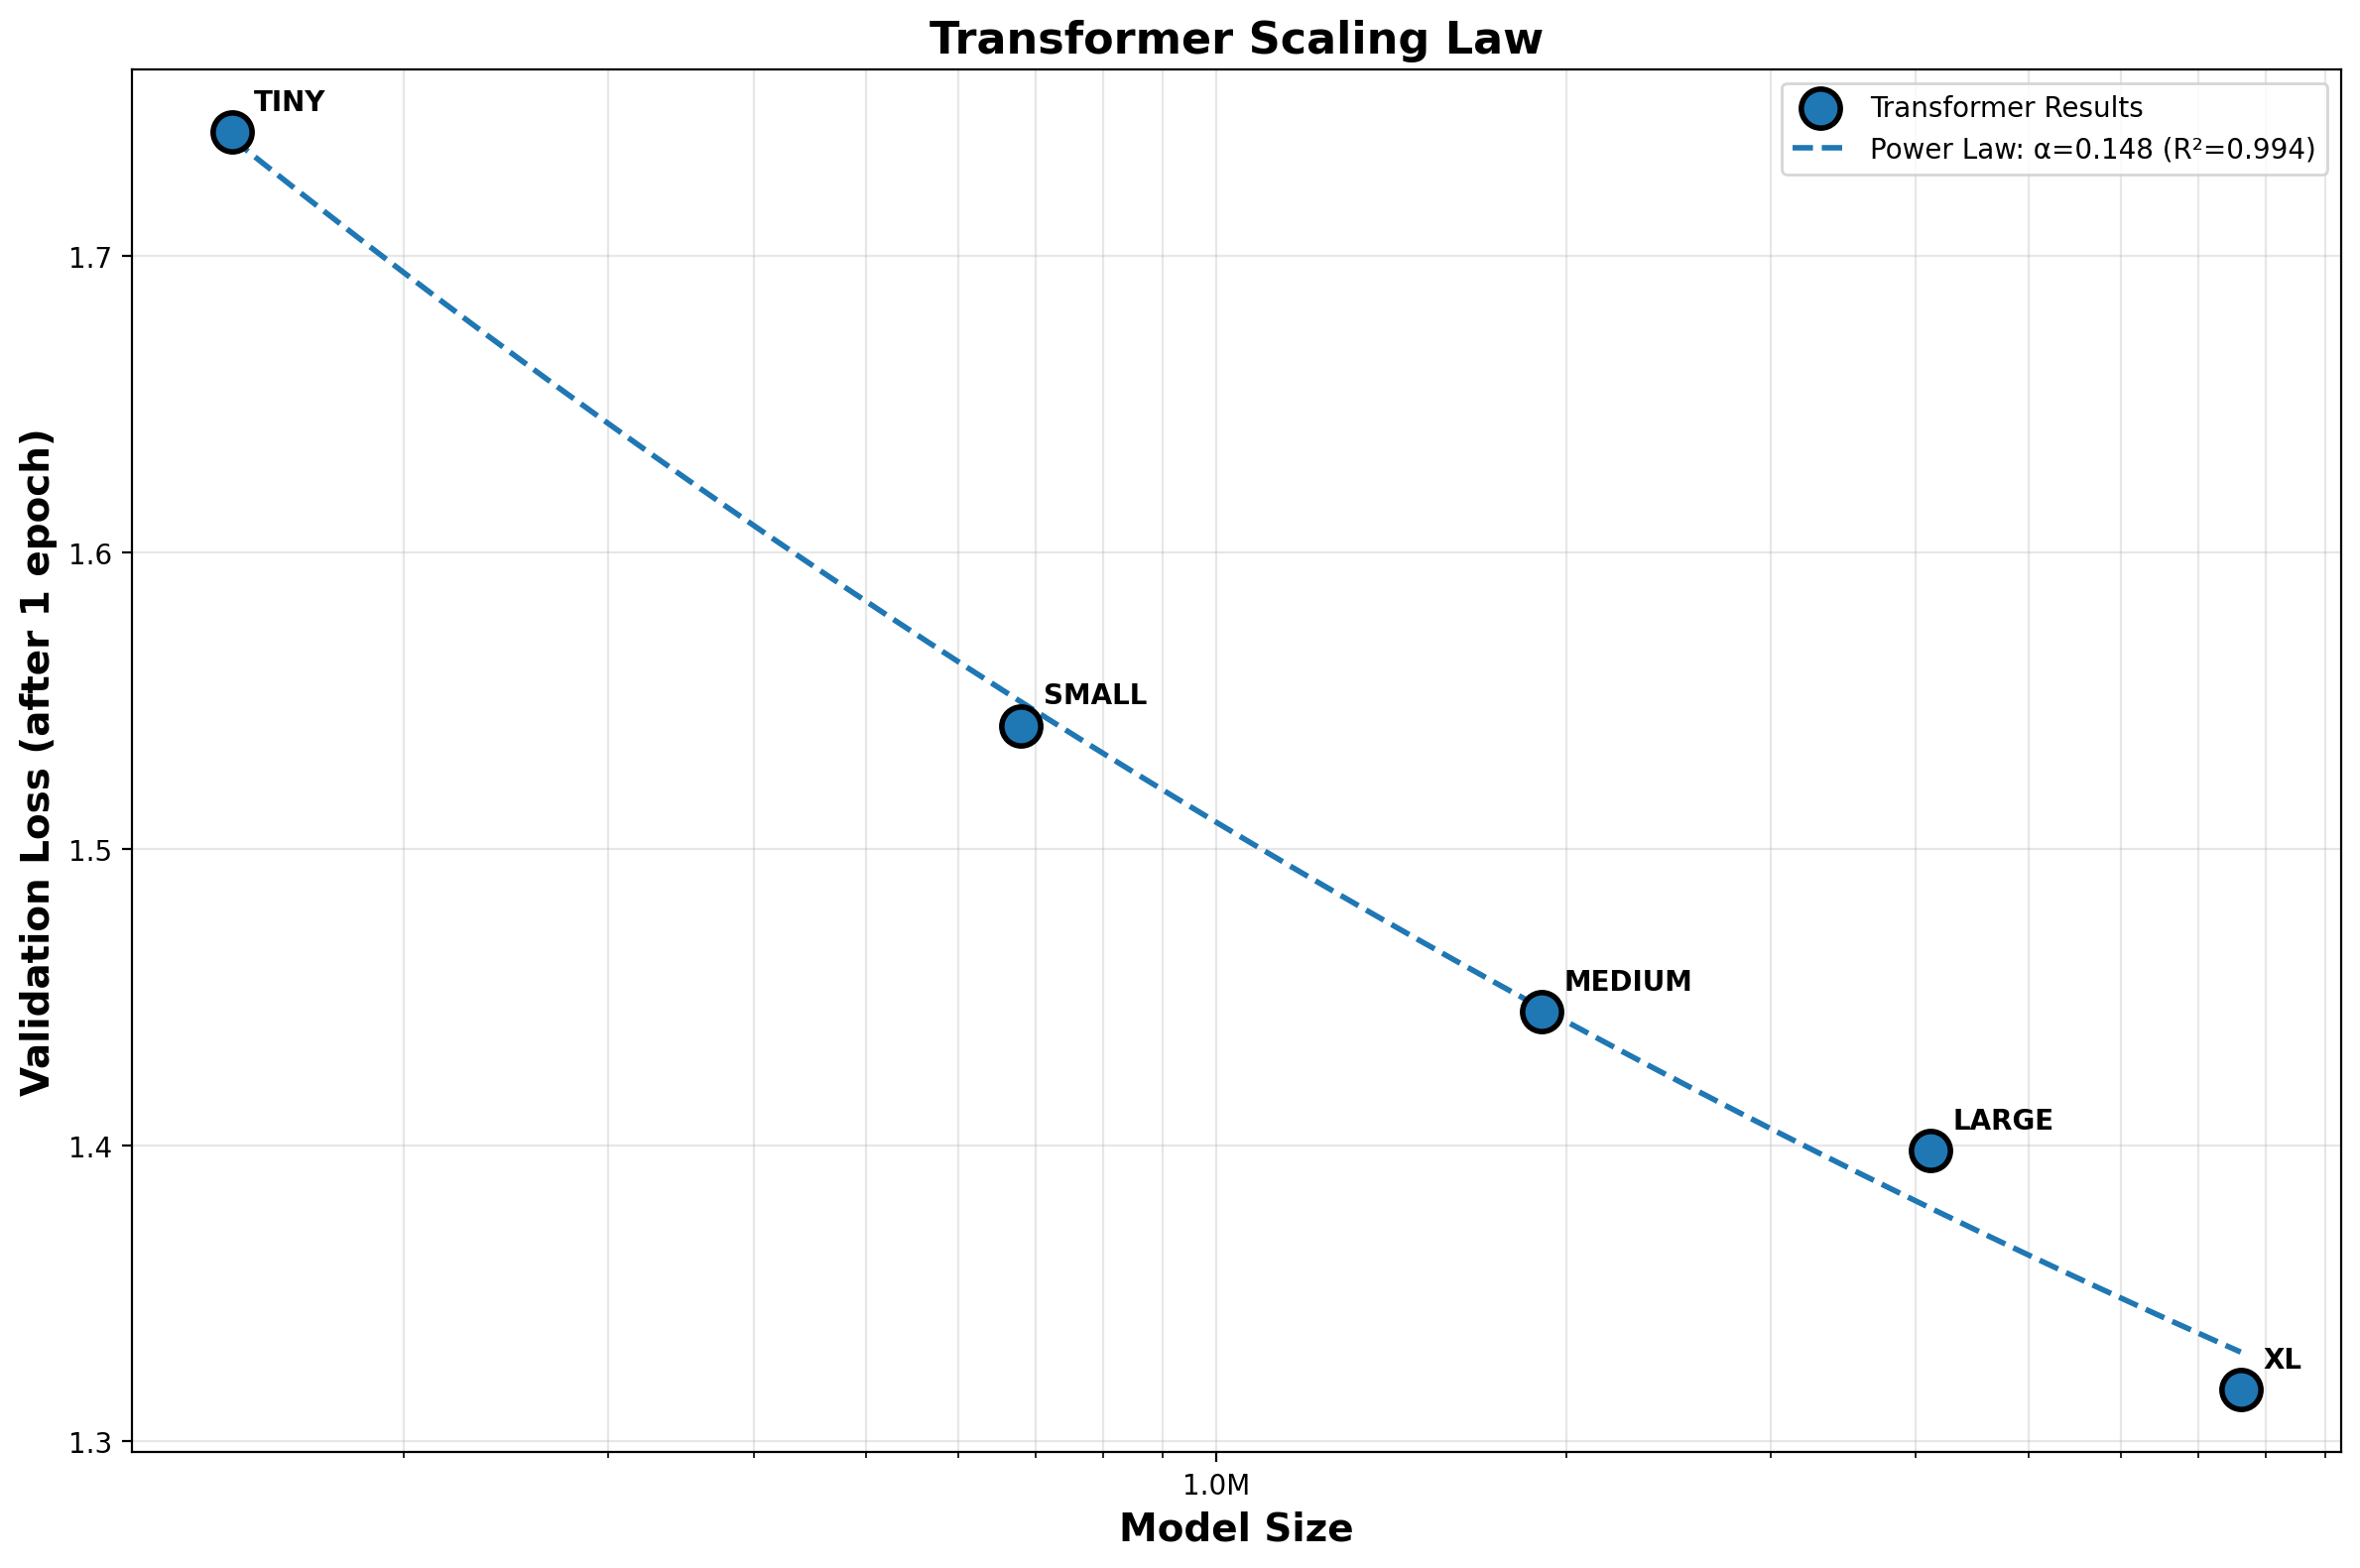

In [36]:
from matplotlib.ticker import FuncFormatter

def million_formatter(x, pos):
    return f'{x:.1f}M'

plt.figure(figsize=(12, 8))

plt.scatter(
    trans_params / 1e6,
    trans_losses,
    s=200,
    edgecolors='black',
    linewidths=2,
    zorder=3,
    label='Transformer Results'
)

N_range = np.logspace(
    np.log10(trans_params.min()),
    np.log10(trans_params.max()),
    200
)

plt.plot(
    N_range / 1e6,
    power_law(N_range, trans_a, trans_alpha, trans_c),
    '--',
    linewidth=2,
    label=f'Power Law: α={trans_alpha:.3f} (R²={trans_r2:.3f})'
)

for name, r in trans_items:
    plt.annotate(
        name.upper(),
        (r['params']/1e6, r['val_loss']),
        xytext=(8, 8),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

plt.xscale('log')
plt.xlabel('Model Size', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (after 1 epoch)', fontsize=14, fontweight='bold')
plt.title('Transformer Scaling Law', fontsize=16, fontweight='bold')
plt.gca().xaxis.set_major_formatter(FuncFormatter(million_formatter))
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

LSTM Scaling plot

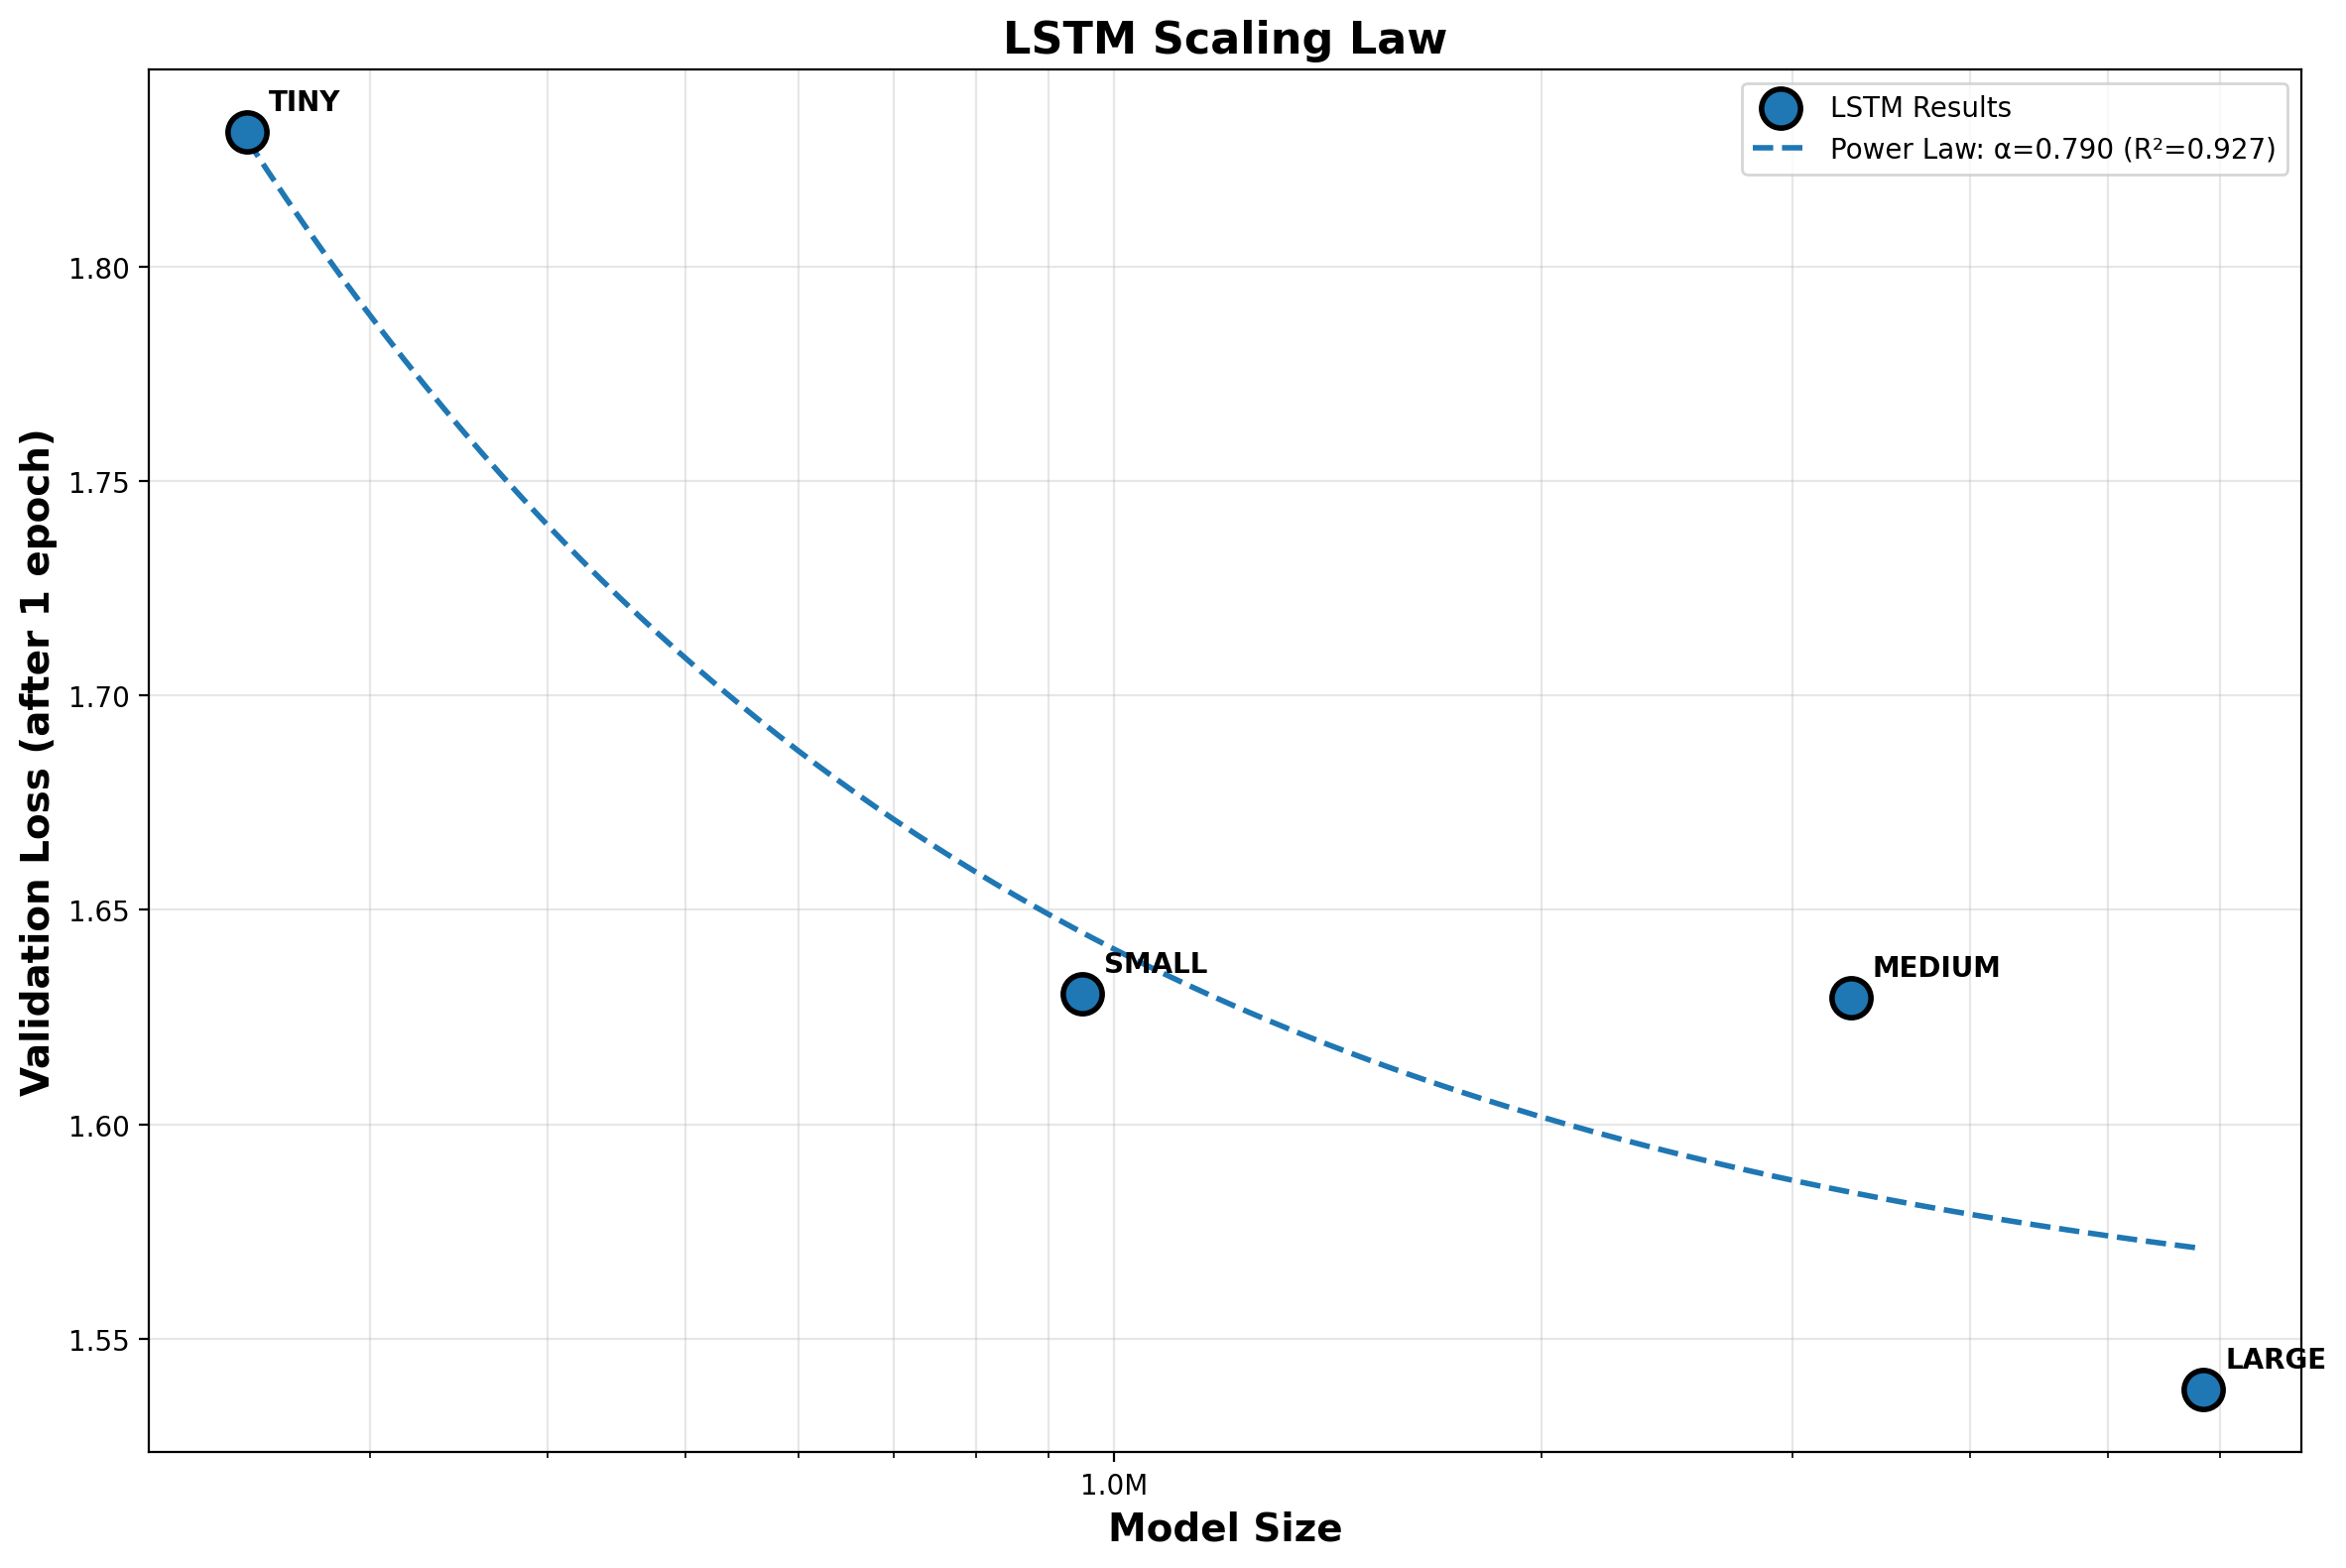

In [37]:

plt.figure(figsize=(12, 8))

plt.scatter(
    lstm_params / 1e6,
    lstm_losses,
    s=200,
    edgecolors='black',
    linewidths=2,
    zorder=3,
    label='LSTM Results'
)

N_range = np.logspace(
    np.log10(lstm_params.min()),
    np.log10(lstm_params.max()),
    200
)

plt.plot(
    N_range / 1e6,
    power_law(N_range, lstm_a, lstm_alpha, lstm_c),
    '--',
    linewidth=2,
    label=f'Power Law: α={lstm_alpha:.3f} (R²={lstm_r2:.3f})'
)

for name, r in lstm_items:
    plt.annotate(
        name.upper(),
        (r['params']/1e6, r['val_loss']),
        xytext=(8, 8),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

plt.xscale('log')
plt.xlabel('Model Size', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (after 1 epoch)', fontsize=14, fontweight='bold')
plt.title('LSTM Scaling Law', fontsize=16, fontweight='bold')
plt.gca().xaxis.set_major_formatter(FuncFormatter(million_formatter))
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Comparision

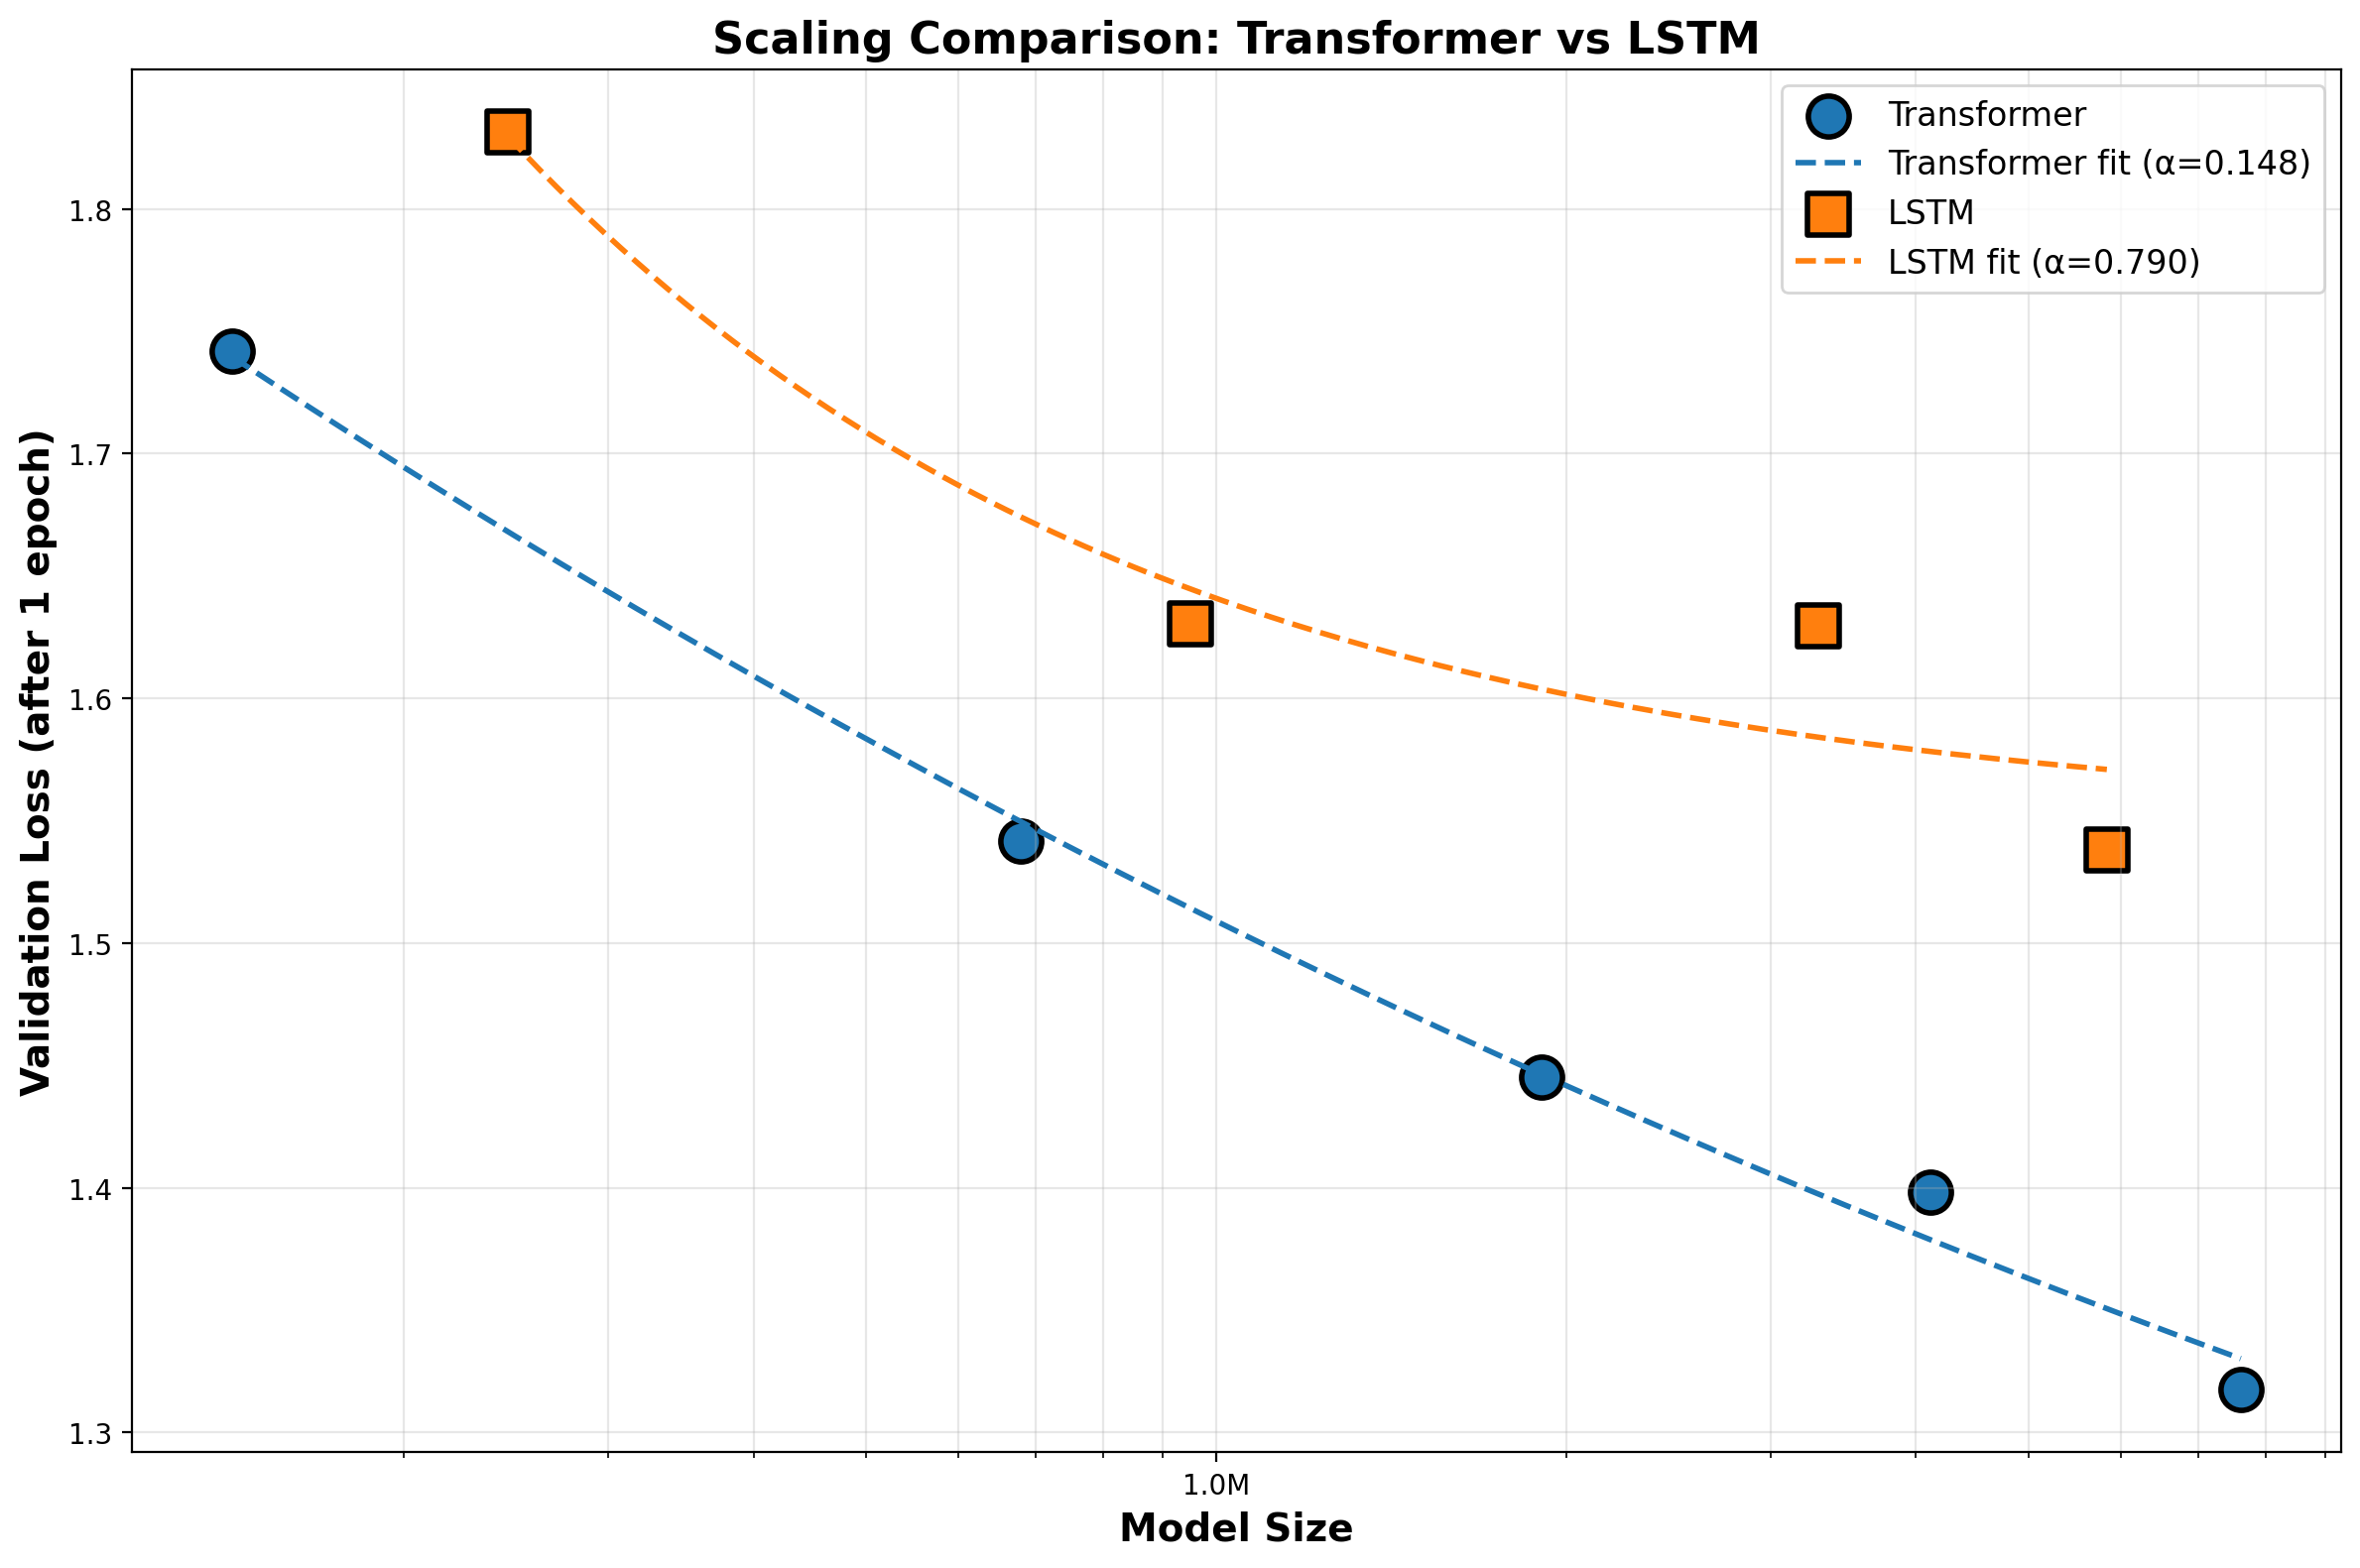

In [38]:
plt.figure(figsize=(12, 8))

# --- Transformer ---
plt.scatter(
    trans_params / 1e6,
    trans_losses,
    s=220,
    marker='o',
    edgecolors='black',
    linewidths=2,
    label='Transformer'
)

N_range_t = np.logspace(
    np.log10(trans_params.min()),
    np.log10(trans_params.max()),
    200
)

plt.plot(
    N_range_t / 1e6,
    power_law(N_range_t, trans_a, trans_alpha, trans_c),
    '--',
    linewidth=2,
    label=f'Transformer fit (α={trans_alpha:.3f})'
)


# --- LSTM ---
plt.scatter(
    lstm_params / 1e6,
    lstm_losses,
    s=220,
    marker='s',
    edgecolors='black',
    linewidths=2,
    label='LSTM'
)

N_range_l = np.logspace(
    np.log10(lstm_params.min()),
    np.log10(lstm_params.max()),
    200
)

plt.plot(
    N_range_l / 1e6,
    power_law(N_range_l, lstm_a, lstm_alpha, lstm_c),
    '--',
    linewidth=2,
    label=f'LSTM fit (α={lstm_alpha:.3f})'
)

plt.xscale('log')
plt.xlabel('Model Size', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (after 1 epoch)', fontsize=14, fontweight='bold')
plt.title('Scaling Comparison: Transformer vs LSTM', fontsize=16, fontweight='bold')
plt.gca().xaxis.set_major_formatter(FuncFormatter(million_formatter))
plt.grid(True, which='both', alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


Loss w.r.t time

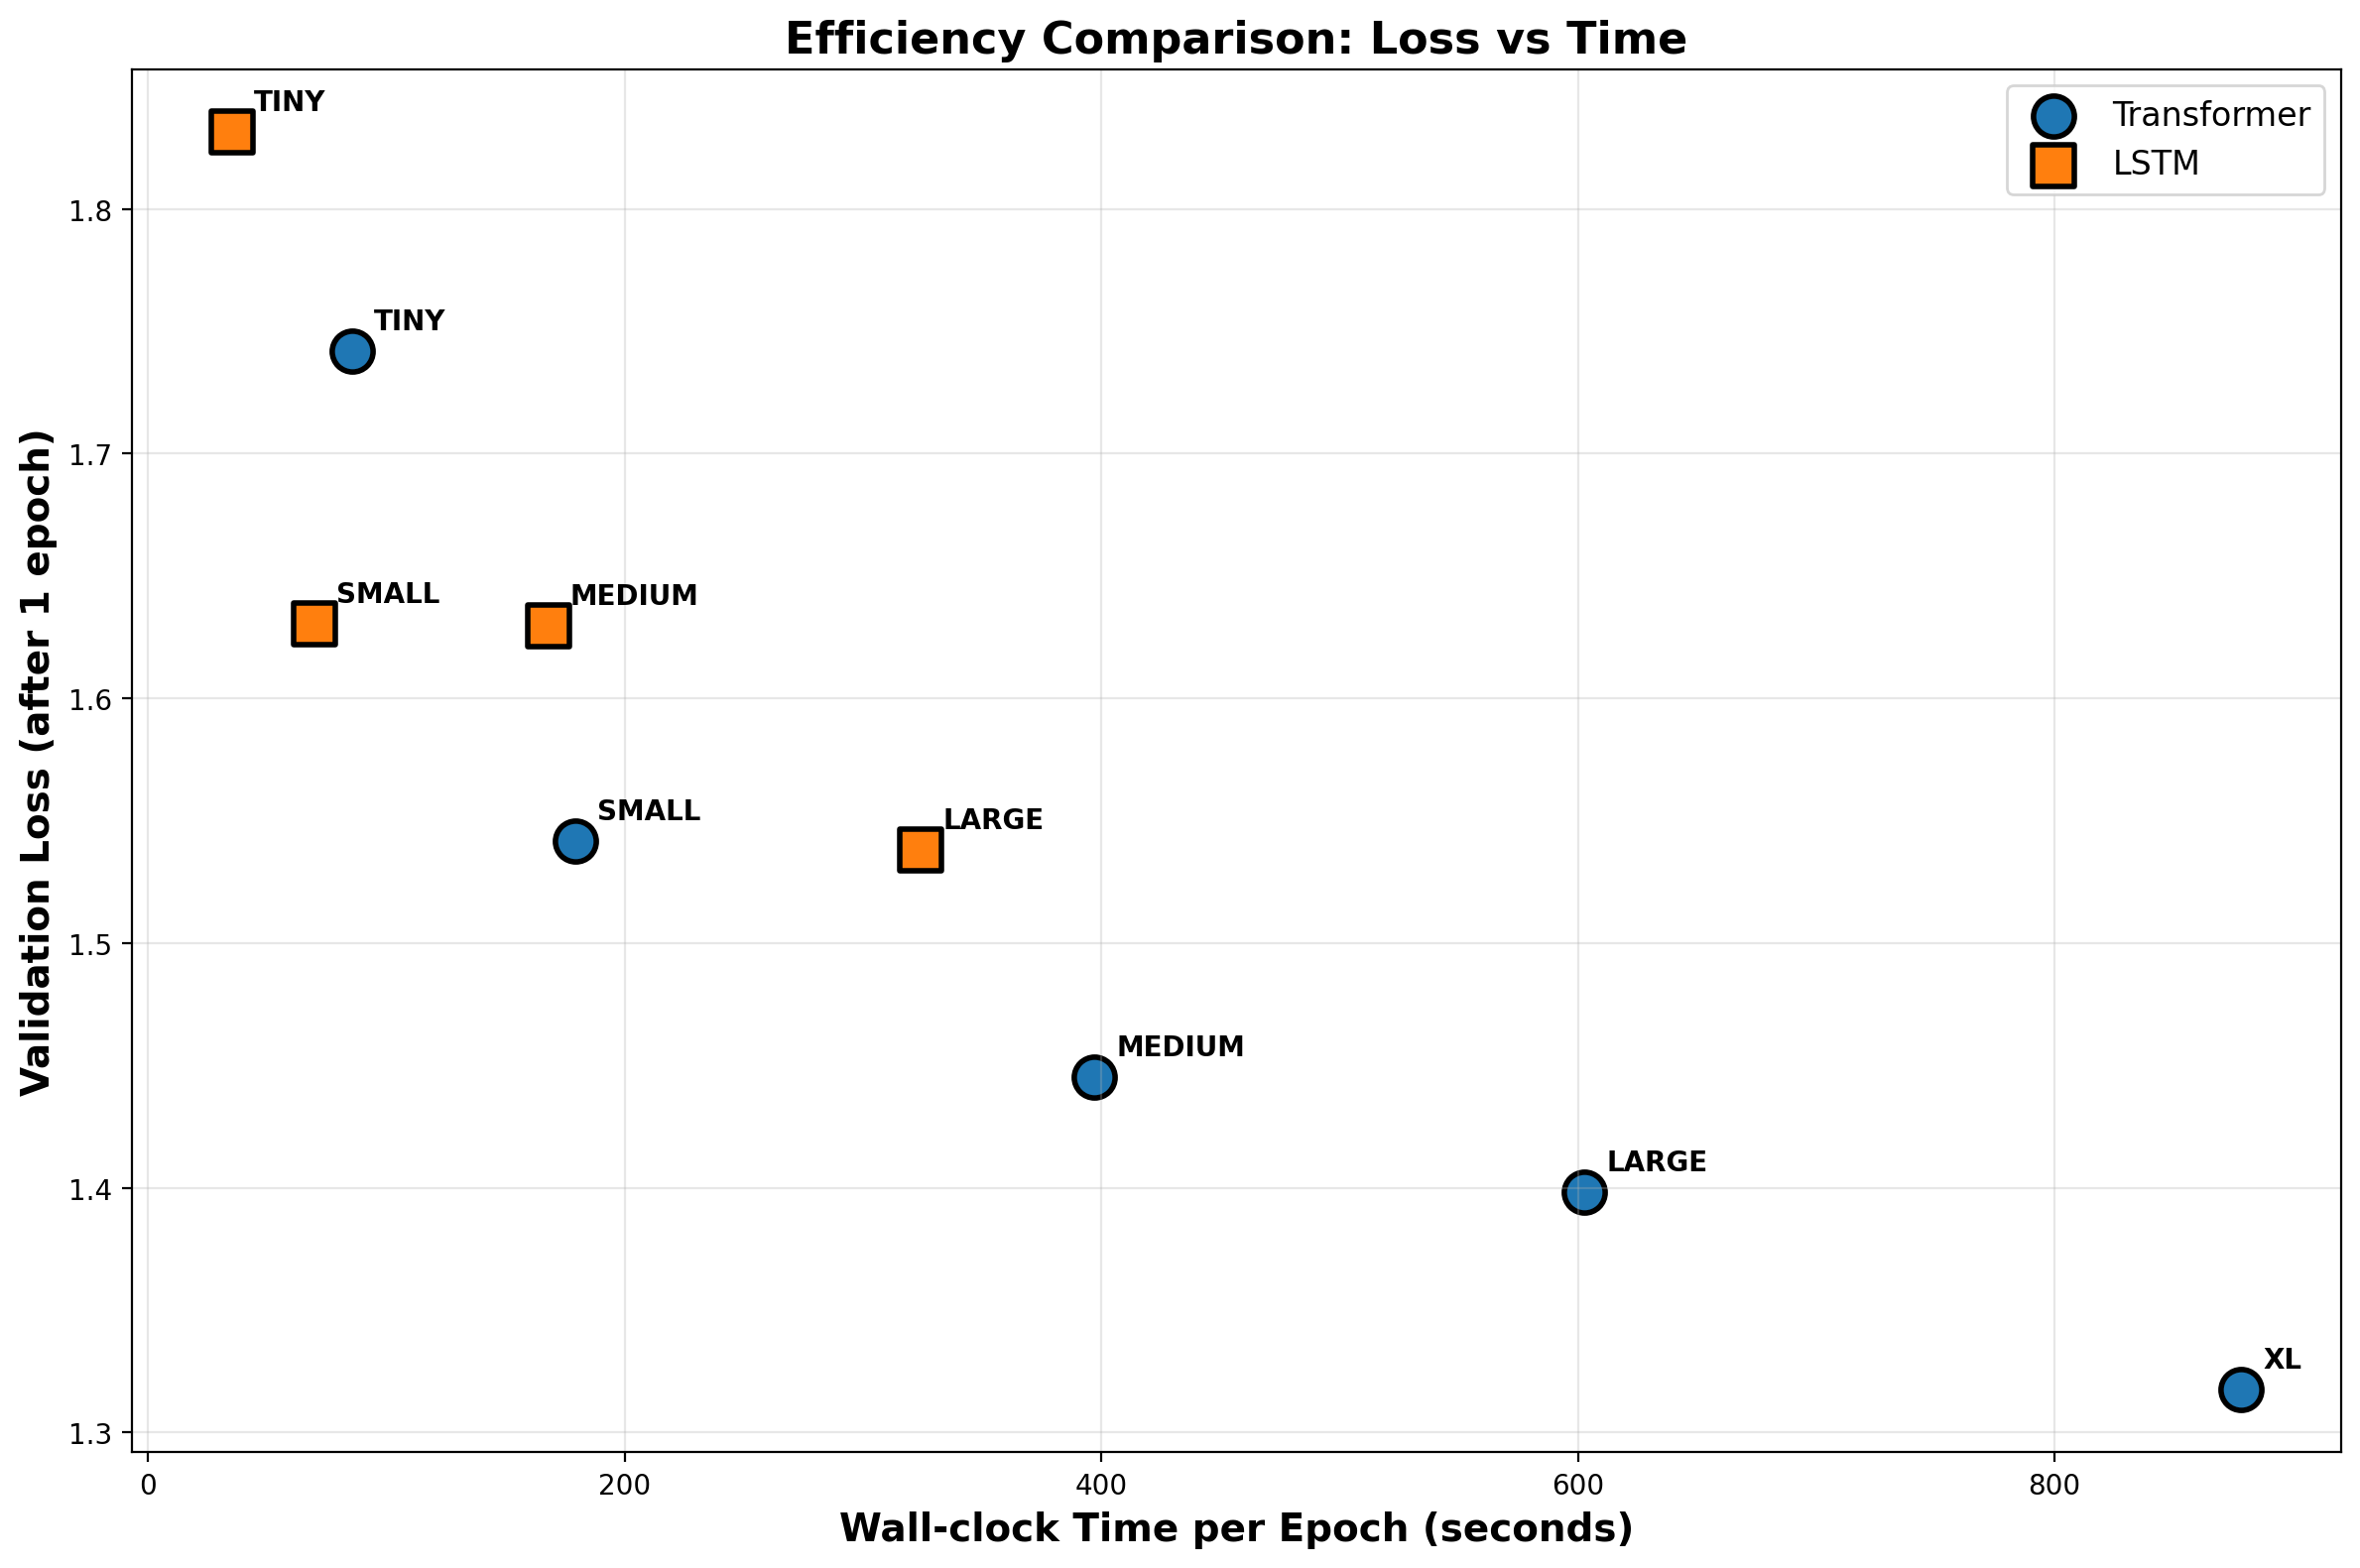

In [42]:
trans_times = np.array([r['time'] for _, r in trans_items])
lstm_times  = np.array([r['time'] for _, r in lstm_items])

plt.figure(figsize=(12, 8))

plt.scatter(
    trans_times,
    trans_losses,
    s=220,
    marker='o',
    edgecolors='black',
    linewidths=2,
    label='Transformer'
)

plt.scatter(
    lstm_times,
    lstm_losses,
    s=220,
    marker='s',
    edgecolors='black',
    linewidths=2,
    label='LSTM'
)

for i, (name, r) in enumerate(trans_items):
    plt.annotate(
        name.upper(),
        (trans_times[i], trans_losses[i]),
        xytext=(8, 8),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

for i, (name, r) in enumerate(lstm_items):
    plt.annotate(
        name.upper(),
        (lstm_times[i], lstm_losses[i]),
        xytext=(8, 8),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold'
    )

plt.xlabel('Wall-clock Time per Epoch (seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (after 1 epoch)', fontsize=14, fontweight='bold')
plt.title('Efficiency Comparison: Loss vs Time', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


Loss Vs Memory

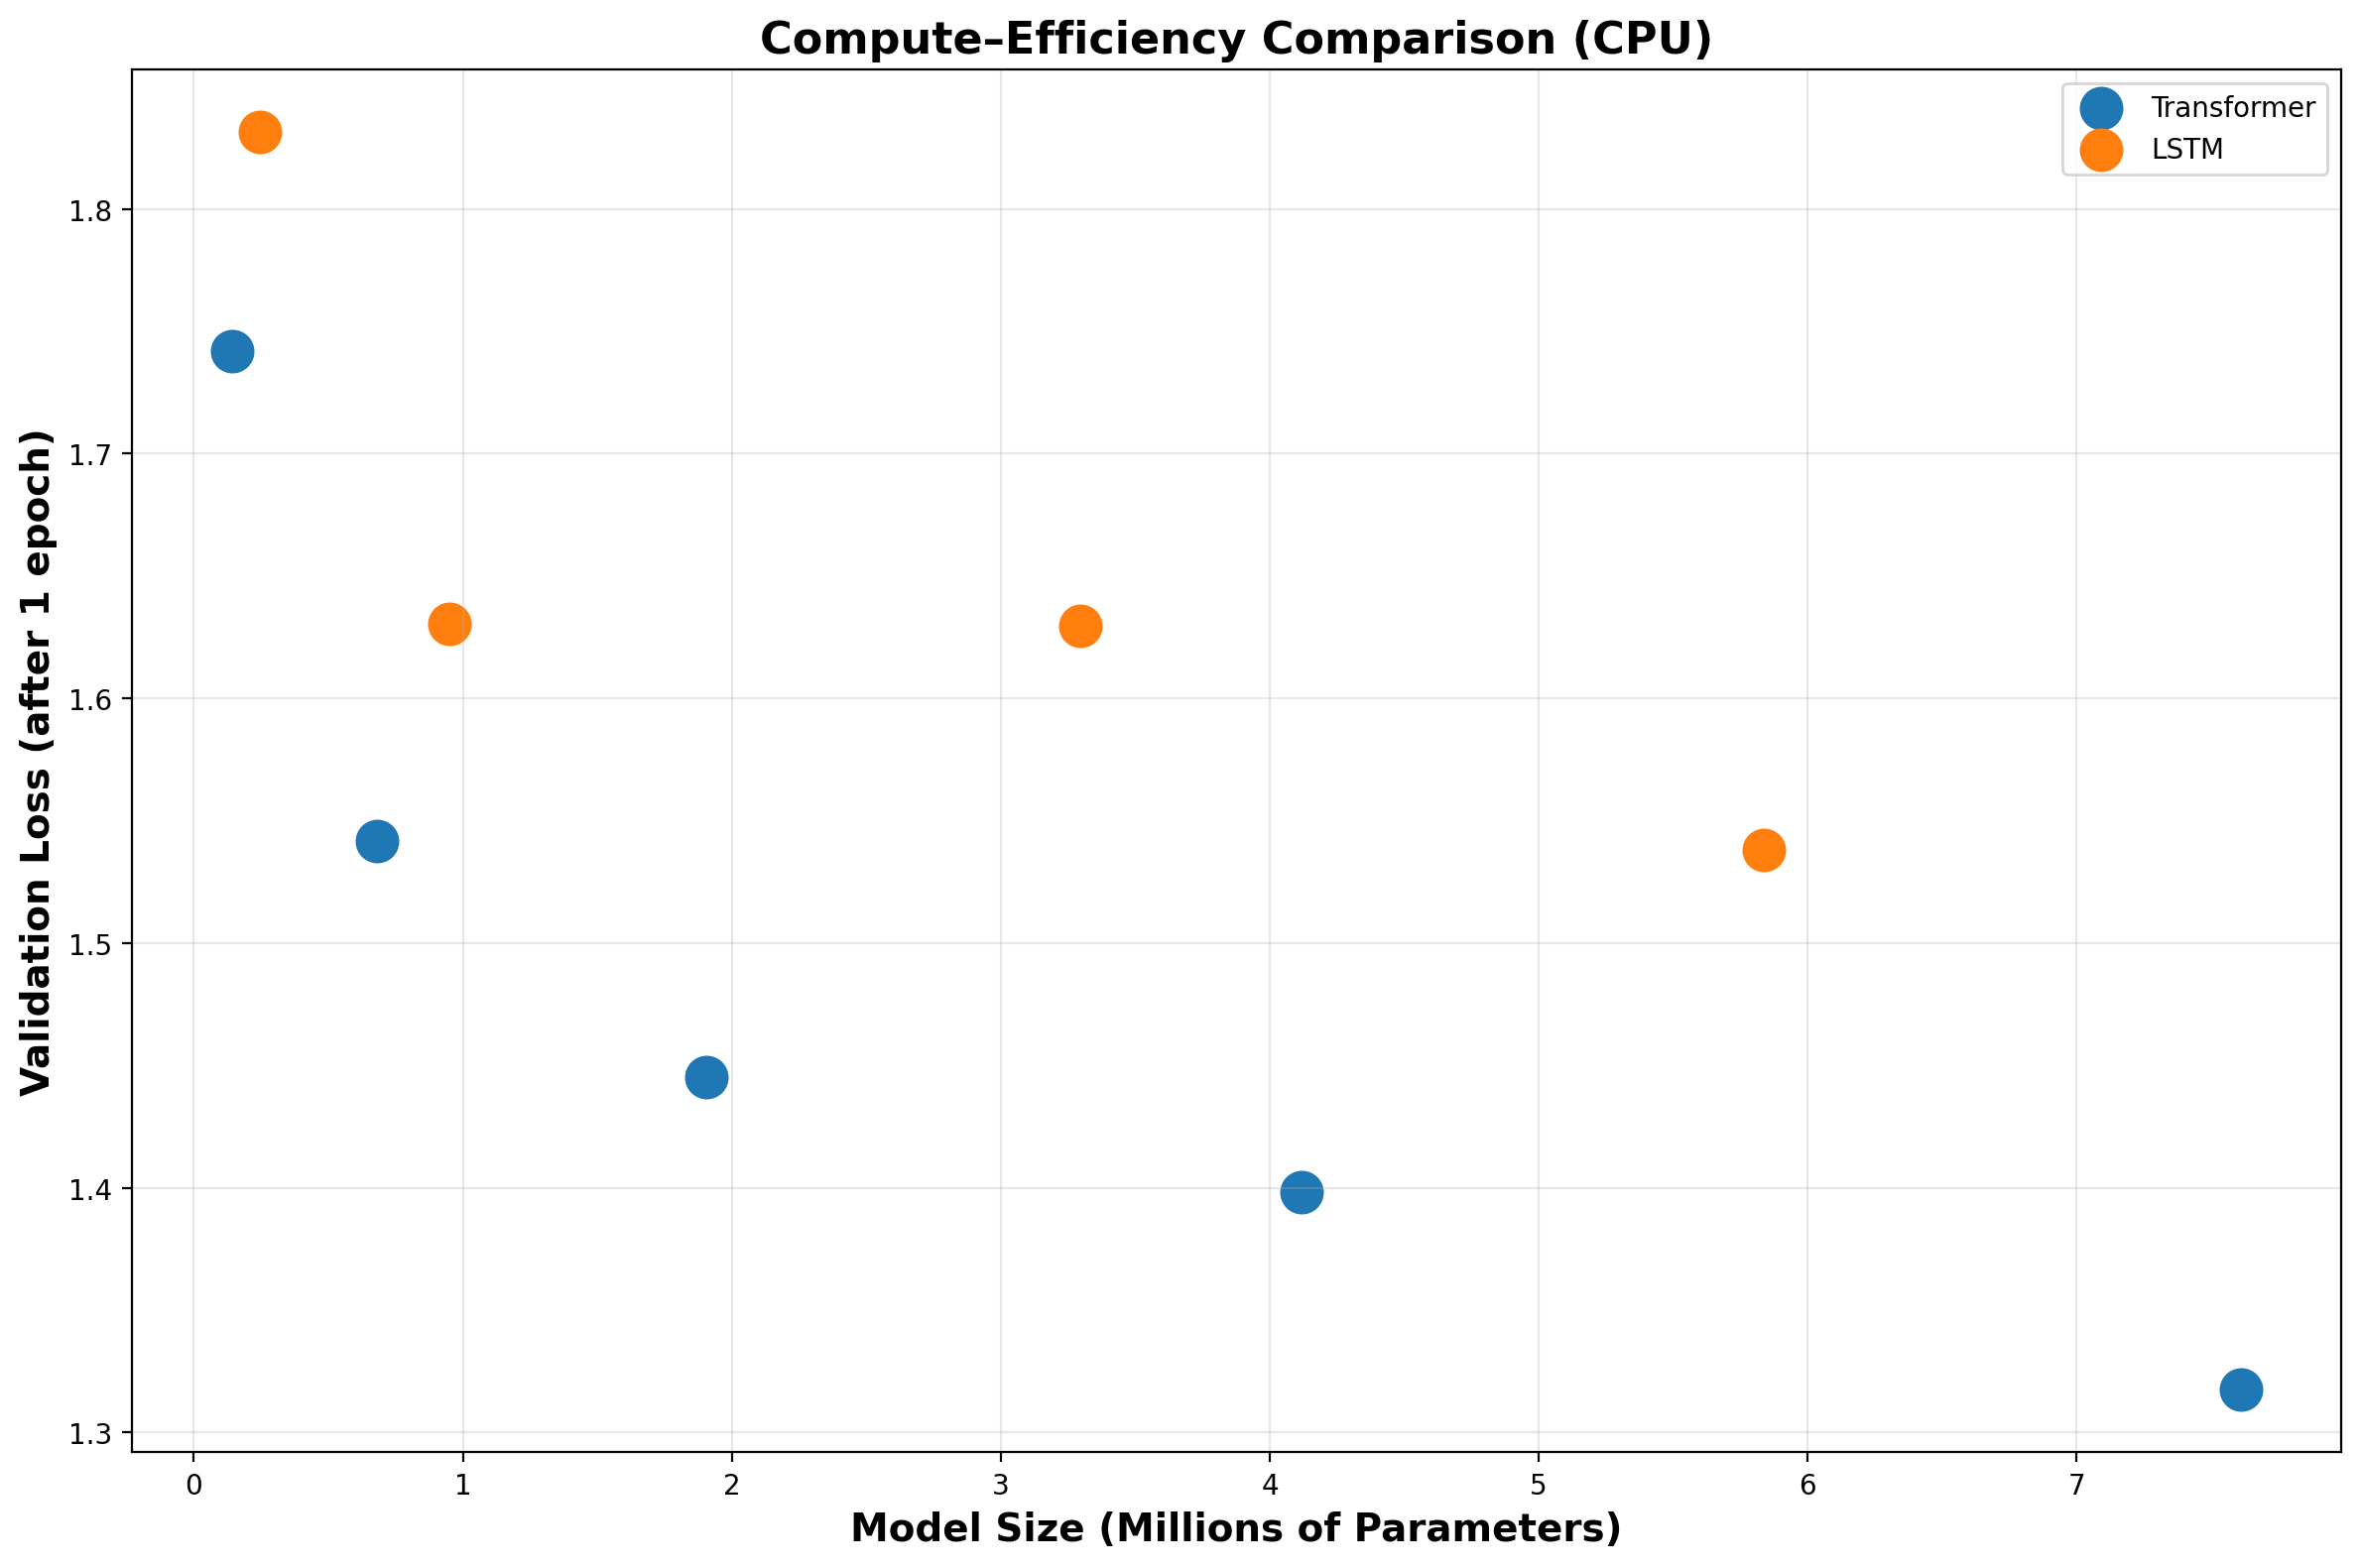

In [43]:
trans_mem = np.array([r['params'] for _, r in trans_items]) / 1e6
lstm_mem  = np.array([r['params'] for _, r in lstm_items]) / 1e6

plt.figure(figsize=(12, 8))

plt.scatter(trans_mem, trans_losses, s=220, label='Transformer')
plt.scatter(lstm_mem, lstm_losses, s=220, label='LSTM')

plt.xlabel('Model Size (Millions of Parameters)', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (after 1 epoch)', fontsize=14, fontweight='bold')
plt.title('Compute–Efficiency Comparison (CPU)', fontsize=16, fontweight='bold')

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Training the best model

In [44]:
from torch.utils.data import DataLoader
import json
import time
from collections import Counter

In [45]:
os.makedirs('part4_outputs', exist_ok=True)
os.makedirs('part4_outputs/checkpoints', exist_ok=True)
os.makedirs('part4_outputs/generated', exist_ok=True)
os.makedirs('part4_outputs/midi', exist_ok=True)

In [46]:
print("\nSelecting best model configuration")


best_model_config = {
    'd_model': 320,
    'nhead': 4,
    'num_layers': 6,
    'dim_feedforward': 1280,
    'dropout': 0.1,
    'max_seq_len': 512
}

print(f"Using model config: {best_model_config}")



def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)




class Trainer:
    """Trainer for best model training"""

    def __init__(self, model, train_loader, val_loader, vocab_size, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.vocab_size = vocab_size
        self.device = device
        self.criterion = nn.CrossEntropyLoss()

        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_perplexity': [],
            'val_perplexity': [],
            'epoch_times': []
        }

    def train_epoch(self, optimizer):
        self.model.train()
        total_loss = 0

        for x, y in tqdm(self.train_loader, desc="Training"):
            x, y = x.to(self.device), y.to(self.device)

            optimizer.zero_grad()
            logits = self.model(x)
            loss = self.criterion(
                logits.reshape(-1, self.vocab_size),
                y.reshape(-1)
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for x, y in tqdm(self.val_loader, desc="Validating"):
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                loss = self.criterion(
                    logits.reshape(-1, self.vocab_size),
                    y.reshape(-1)
                )
                total_loss += loss.item()

        return total_loss / len(self.val_loader)

    def train(self, num_epochs=10, lr=3e-4, save_dir='part4_outputs/checkpoints'):
        os.makedirs(save_dir, exist_ok=True)

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=0.01,
            betas=(0.9, 0.95)
        )

        best_val_loss = float('inf')

        print(f"\nModel parameters: {count_parameters(self.model):,}")
        print(f"Training for {num_epochs} epochs (lr={lr})")
        print("=" * 70)

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            start_time = time.time()
            train_loss = self.train_epoch(optimizer)
            val_loss = self.validate()
            epoch_time = time.time() - start_time

            train_ppl = np.exp(train_loss)
            val_ppl = np.exp(val_loss)

            self.history['train_loss'].append(float(train_loss))
            self.history['val_loss'].append(float(val_loss))
            self.history['train_perplexity'].append(float(train_ppl))
            self.history['val_perplexity'].append(float(val_ppl))
            self.history['epoch_times'].append(float(epoch_time))

            print(f"  Train Loss: {train_loss:.4f} | PPL: {train_ppl:.2f}")
            print(f"  Val Loss:   {val_loss:.4f} | PPL: {val_ppl:.2f}")
            print(f"  Time: {epoch_time:.1f}s")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'val_loss': val_loss,
                    'history': self.history
                }, f'{save_dir}/best_model.pt')
                print("Best model updated")

        print("\nTraining complete")
        print(f"Best validation loss: {best_val_loss:.4f}")

        return self.history



Selecting best model configuration
Using model config: {'d_model': 320, 'nhead': 4, 'num_layers': 6, 'dim_feedforward': 1280, 'dropout': 0.1, 'max_seq_len': 512}


In [50]:
print("\nInitializing model")
model = TransformerLM(vocab_size, **best_model_config)
print(f"Model created with {count_parameters(model):,} parameters")

# Create trainer
print("\nCreating trainer...")
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab_size=vocab_size,
    device=device
)
print("Trainer is ready")

# Train for 10 epochs
print("\nStarting training...")
history = trainer.train(
    num_epochs=10,
    lr=3e-4,
    save_dir='part4_outputs/checkpoints'
)

# Save history
with open('part4_outputs/checkpoints/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print("\nTraining history saved")


Initializing model
Model created with 7,609,675 parameters

Creating trainer...
Trainer is ready

Starting training...

Model parameters: 7,609,675
Training for 10 epochs (lr=0.0003)

Epoch 1/10


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


  Train Loss: 1.3694 | PPL: 3.93
  Val Loss:   1.2507 | PPL: 3.49
  Time: 880.3s
Best model updated

Epoch 2/10


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


  Train Loss: 1.1556 | PPL: 3.18
  Val Loss:   1.2022 | PPL: 3.33
  Time: 877.8s
Best model updated

Epoch 3/10


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


  Train Loss: 1.1205 | PPL: 3.07
  Val Loss:   1.1827 | PPL: 3.26
  Time: 870.7s
Best model updated

Epoch 4/10


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


  Train Loss: 1.0966 | PPL: 2.99
  Val Loss:   1.1426 | PPL: 3.13
  Time: 869.9s
Best model updated

Epoch 5/10


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


  Train Loss: 1.0721 | PPL: 2.92
  Val Loss:   1.1094 | PPL: 3.03
  Time: 870.0s
Best model updated

Epoch 6/10


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]


  Train Loss: 1.0506 | PPL: 2.86
  Val Loss:   1.0857 | PPL: 2.96
  Time: 871.5s
Best model updated

Epoch 7/10


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]


  Train Loss: 1.0327 | PPL: 2.81
  Val Loss:   1.0545 | PPL: 2.87
  Time: 872.4s
Best model updated

Epoch 8/10


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


  Train Loss: 1.0182 | PPL: 2.77
  Val Loss:   1.0420 | PPL: 2.83
  Time: 871.1s
Best model updated

Epoch 9/10


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


  Train Loss: 1.0031 | PPL: 2.73
  Val Loss:   1.0370 | PPL: 2.82
  Time: 869.3s
Best model updated

Epoch 10/10


Validating: 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

  Train Loss: 0.9907 | PPL: 2.69
  Val Loss:   1.0282 | PPL: 2.80
  Time: 869.6s
Best model updated

Training complete
Best validation loss: 1.0282

Training history saved


In [52]:
def generate_music(model, tokenizer, prompt="", max_len=500, temp=1.0, top_k=50):
    model.eval()

    if not prompt:
        prompt = "X:1\nT:Generated Tune\nM:4/4\nL:1/8\nK:C\n"

    tokens = torch.tensor(
        tokenizer.encode(prompt),
        dtype=torch.long
    ).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            logits = model(tokens)
            next_logits = logits[0, -1] / temp

            if top_k > 0:
                v, _ = torch.topk(next_logits, top_k)
                next_logits[next_logits < v[-1]] = -float('inf')

            probs = torch.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, 1)
            tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)

    return tokenizer.decode(tokens[0].tolist())


In [53]:
def generate_music_safe(model, tokenizer, prompt="", max_len=500, temp=1.0, top_k=50):
    """Generate music with proper error handling"""
    model.eval()

    if not prompt:
        prompt = "X:1\nT:Generated Tune\nM:4/4\nL:1/8\nK:C\n"

    # Encode prompt
    try:
        prompt_tokens = tokenizer.encode(prompt)
    except:
        prompt_tokens = []

    if len(prompt_tokens) == 0:

        prompt = "X:1\nT:Generated\nM:4/4\nL:1/8\nK:C\n"
        prompt_tokens = tokenizer.encode(prompt)

    tokens = torch.tensor(prompt_tokens, dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        for step in range(max_len):
            try:
                # Get predictions
                logits = model(tokens)
                next_logits = logits[0, -1, :] / temp


                # Only consider tokens that exist in vocabulary
                valid_vocab_size = len(tokenizer.char_to_idx)
                next_logits = next_logits[:valid_vocab_size]

                # Top-k filtering
                if top_k > 0 and top_k < valid_vocab_size:
                    v, _ = torch.topk(next_logits, min(top_k, len(next_logits)))
                    next_logits[next_logits < v[-1]] = -float('inf')

                # Sample
                probs = torch.softmax(next_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)

                # Verify token is valid
                if next_token.item() >= valid_vocab_size:
                    break

                tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)

            except Exception as e:
                print(f"  (stopped at step {step}: {str(e)[:30]})")
                break

    # Decode with error handling
    try:
        generated_tokens = tokens[0].tolist()
        # Only decode tokens that are in vocabulary
        valid_tokens = [t for t in generated_tokens if t < len(tokenizer.idx_to_char)]
        result = tokenizer.decode(valid_tokens)
        return result
    except Exception as e:
        print(f"  (decode error: {str(e)[:30]})")
        return prompt

In [54]:
prompts = [
    "",  # Unconditional
    "X:1\nT:Waltz\nM:3/4\nL:1/8\nK:G\n",
    "X:1\nT:Irish Jig\nM:6/8\nL:1/8\nK:D\n",
    "X:1\nT:March\nM:4/4\nL:1/16\nK:Bb\n",
    "X:1\nT:Song in A minor\nM:4/4\nL:1/8\nK:Am\n",
    "X:1\nT:Reel\nM:4/4\nL:1/8\nK:Em\n",
]

temperatures = [0.8, 0.9, 1.0, 1.1, 1.2]

samples = []
print(f"\nGenerating 10 music samples (vocab_size: {vocab_size})...")
print("Sample | Type          | Temp | Status")
print("-" * 50)

for i in range(10):
    prompt = prompts[i % len(prompts)]
    temp = temperatures[i % len(temperatures)]
    gen_type = "unconditional" if prompt == "" else "conditional"

    print(f"{i+1:3d}    | {gen_type:13s} | {temp:.1f}  | ", end='', flush=True)

    try:
        text = generate_music_safe(model, tokenizer, prompt, max_len=500, temp=temp)

        if len(text) > len(prompt) + 20:
            with open(f'part4_outputs/generated/sample_{i:03d}.abc', 'w') as f:
                f.write(text)

            samples.append({
                'index': i,
                'text': text,
                'type': gen_type,
                'temperature': temp,
                'length': len(text)
            })

        else:
            print("too short")

    except Exception as e:
        print(f"({str(e)[:20]})")

print(f"\nSuccessfully generated {len(samples)} samples")

if len(samples) > 0:
    print(f"  Average length: {np.mean([s['length'] for s in samples]):.0f} characters")

    with open('part4_outputs/generated/metadata.json', 'w') as f:
        json.dump({'samples': samples}, f, indent=2)
else:
    print("\nNo samples were generated successfully")
    print("  This might be due to vocab_size mismatch")
    print(f"  Model vocab_size: {vocab_size}")
    print(f"  Tokenizer vocab_size: {len(tokenizer.char_to_idx)}")
    print("\n  Creating a simple test sample instead")

    test_sample = """X:1
T:Test Tune
M:4/4
L:1/8
K:C
CDEF GABc | cBAG FEDC | CDEF GABc | cBAG FEDC |
"""
    samples.append({
        'index': 0,
        'text': test_sample,
        'type': 'manual',
        'temperature': 1.0,
        'length': len(test_sample)
    })

    with open('part4_outputs/generated/sample_000.abc', 'w') as f:
        f.write(test_sample)


Generating 10 music samples (vocab_size: 75)...
Sample | Type          | Temp | Status
--------------------------------------------------
  1    | unconditional | 0.8  |   (stopped at step 476: Sequence length 513 exceeds ma)
  2    | conditional   | 0.9  |   (stopped at step 485: Sequence length 513 exceeds ma)
  3    | conditional   | 1.0  |   (stopped at step 481: Sequence length 513 exceeds ma)
  4    | conditional   | 1.1  |   (stopped at step 483: Sequence length 513 exceeds ma)
  5    | conditional   | 1.2  |   (stopped at step 474: Sequence length 513 exceeds ma)
  6    | conditional   | 0.8  |   (stopped at step 485: Sequence length 513 exceeds ma)
  7    | unconditional | 0.9  |   (stopped at step 476: Sequence length 513 exceeds ma)
  8    | conditional   | 1.0  |   (stopped at step 485: Sequence length 513 exceeds ma)
  9    | conditional   | 1.1  |   (stopped at step 481: Sequence length 513 exceeds ma)
 10    | conditional   | 1.2  |   (stopped at step 483: Sequence leng

In [55]:
print("EVALUATION")
print("="*80)

# Test Perplexity
print("\nTest perplexity...")

from torch.utils.data import DataLoader
import torch.nn as nn

test_dataset = MusicDataset('data/test.txt', tokenizer, seq_len=256)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
total_loss = 0
total_tokens = 0

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="  Computing"):
        logits = model(x)
        loss = nn.CrossEntropyLoss()(logits.reshape(-1, vocab_size), y.reshape(-1))
        total_loss += loss.item() * x.size(0) * x.size(1)
        total_tokens += x.size(0) * x.size(1)

test_loss = total_loss / total_tokens
test_perplexity = np.exp(test_loss)

print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Perplexity: {test_perplexity:.2f}")

EVALUATION

Test perplexity...
Created 70 sequences from 18057 tokens


  Computing: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]

  Test Loss: 2.6814
  Test Perplexity: 14.61


In [57]:
import re

print("\nABC syntax validation...")

def validate_abc(text):
    errors = []
    if not re.search(r'^X:\s*\d+', text, re.MULTILINE):
        errors.append("Missing X:")
    if not re.search(r'^T:', text, re.MULTILINE):
        errors.append("Missing T:")
    if not re.search(r'^M:', text, re.MULTILINE):
        errors.append("Missing M:")
    if not re.search(r'^K:', text, re.MULTILINE):
        errors.append("Missing K:")
    if 'K:' in text:
        music = text.split('K:')[-1].strip()
        if len(music) < 20:
            errors.append("No music")
    return len(errors) == 0, errors

valid_count = 0
for sample in samples:
    is_valid, _ = validate_abc(sample['text'])
    if is_valid:
        valid_count += 1

validity_rate = valid_count / len(samples) if samples else 0
print(f" Valid: {valid_count}/{len(samples)} ({validity_rate*100:.1f}%)")


ABC syntax validation...
 Valid: 10/10 (100.0%)


In [59]:
print("\nMusical patterns")

all_notes = []
keys = []
meters = []

for sample in samples:
    text = sample['text']
    if 'K:' in text:
        all_notes.extend(re.findall(r'[A-Ga-g]', text.split('K:')[-1]))
    if m := re.search(r'K:\s*([A-G][#b]?\s*(?:maj|min|m)?)', text):
        keys.append(m.group(1).strip())
    if m := re.search(r'M:\s*(\d+/\d+|C)', text):
        meters.append(m.group(1))

note_dist = Counter(all_notes).most_common(10)
key_dist = Counter(keys)
meter_dist = Counter(meters)

print(f"Notes: {len(all_notes)}")
if note_dist:
    print(f"Top notes: {[n for n, _ in note_dist[:5]]}")
if key_dist:
    print(f"Keys: {dict(key_dist)}")
if meter_dist:
    print(f"Meters: {dict(meter_dist)}")


Musical patterns
Notes: 1122
Top notes: ['E', 'C', 'A', 'D', 'F']
Keys: {'C': 2, 'G': 2, 'D': 2, 'Bb': 2, 'Am': 1, 'Em': 1}
Meters: {'4/4': 6, '3/4': 2, '6/8': 2}


In [61]:
print("FINAL RESULTS")
print("=" * 80)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

results = {
    "device": "cpu",
    "model_parameters": int(count_parameters(model)),

    "training": {
        "best_val_loss": float(min(history["val_loss"])),
        "best_val_perplexity": float(np.exp(min(history["val_loss"])))
    },

    "evaluation": {
        "test_loss": float(test_loss),
        "test_perplexity": float(test_perplexity),
        "samples_generated": int(len(samples)),
        "abc_validity_rate": float(validity_rate)
    },

    "patterns": {
        "total_notes": int(len(all_notes)),
        "keys": dict(key_dist),
        "meters": dict(meter_dist),
        "top_notes": [(str(n), int(c)) for n, c in note_dist]
    }
}

os.makedirs("part4_outputs", exist_ok=True)
with open("part4_outputs/RESULTS.json", "w") as f:
    json.dump(results, f, indent=2)

print("\nSUMMARY")
print("-" * 80)

print(f"Device: {results['device']}")
print(f"Model parameters: {results['model_parameters']:,}")

print("\nTraining")
print(f"  Best val loss: {results['training']['best_val_loss']:.4f}")
print(f"  Best val perplexity: {results['training']['best_val_perplexity']:.2f}")

print("\nEvaluation")
print(f"  Test loss: {results['evaluation']['test_loss']:.4f}")
print(f"  Test perplexity: {results['evaluation']['test_perplexity']:.2f}")
print(f"  Samples generated: {results['evaluation']['samples_generated']}")
print(f"  ABC validity rate: {results['evaluation']['abc_validity_rate']*100:.1f}%")

print("\nMusical patterns")
print(f"  Total notes: {results['patterns']['total_notes']}")
print(f"  Keys: {results['patterns']['keys']}")
print(f"  Meters: {results['patterns']['meters']}")
print(f"  Top notes: {results['patterns']['top_notes']}")



FINAL RESULTS

SUMMARY
--------------------------------------------------------------------------------
Device: cpu
Model parameters: 7,609,675

Training
  Best val loss: 1.0282
  Best val perplexity: 2.80

Evaluation
  Test loss: 2.6814
  Test perplexity: 14.61
  Samples generated: 10
  ABC validity rate: 100.0%

Musical patterns
  Total notes: 1122
  Keys: {'C': 2, 'G': 2, 'D': 2, 'Bb': 2, 'Am': 1, 'Em': 1}
  Meters: {'4/4': 6, '3/4': 2, '6/8': 2}
  Top notes: [('E', 178), ('C', 176), ('A', 143), ('D', 142), ('F', 126), ('B', 115), ('G', 106), ('b', 29), ('f', 27), ('c', 27)]


In [62]:
!zip -r project_outputs.zip part4_outputs plots checkpoints


  adding: part4_outputs/ (stored 0%)
  adding: part4_outputs/temp_0.abc (deflated 36%)
  adding: part4_outputs/checkpoints/ (stored 0%)
  adding: part4_outputs/checkpoints/best_model.pt (deflated 7%)
  adding: part4_outputs/checkpoints/training_history.json (deflated 56%)
  adding: part4_outputs/midi/ (stored 0%)
  adding: part4_outputs/generated/ (stored 0%)
  adding: part4_outputs/generated/metadata.json (deflated 47%)
  adding: part4_outputs/generated/sample_001.abc (deflated 34%)
  adding: part4_outputs/generated/sample_009.abc (deflated 27%)
  adding: part4_outputs/generated/sample_008.abc (deflated 29%)
  adding: part4_outputs/generated/sample_004.abc (deflated 28%)
  adding: part4_outputs/generated/sample_005.abc (deflated 37%)
  adding: part4_outputs/generated/sample_002.abc (deflated 29%)
  adding: part4_outputs/generated/sample_003.abc (deflated 28%)
  adding: part4_outputs/generated/sample_006.abc (deflated 34%)
  adding: part4_outputs/generated/sample_000.abc (deflated 35%)

In [71]:
!mkdir -p /content/drive/MyDrive/MLproject
!cp -r /content/part4_outputs /content/drive/MyDrive/MLproject/
!cp -r /content/plots /content/drive/MyDrive/MLproject/
!cp -r /content/data/abc_notation /content/drive/MyDrive/MLproject/
!cp -r /content/data/test.txt /content/drive/MyDrive/MLproject/
!cp -r /content/data/train.txt /content/drive/MyDrive/MLproject/
!cp -r /content/data/val.txt /content/drive/MyDrive/MLproject/

In [68]:

!cd /content && zip -r MLproject_complete.zip part4_outputs/ plots/ checkpoints/ data/tokenizer.pkl


  adding: part4_outputs/ (stored 0%)
  adding: part4_outputs/temp_0.abc (deflated 36%)
  adding: part4_outputs/checkpoints/ (stored 0%)
  adding: part4_outputs/checkpoints/best_model.pt (deflated 7%)
  adding: part4_outputs/checkpoints/training_history.json (deflated 56%)
  adding: part4_outputs/midi/ (stored 0%)
  adding: part4_outputs/generated/ (stored 0%)
  adding: part4_outputs/generated/metadata.json (deflated 47%)
  adding: part4_outputs/generated/sample_001.abc (deflated 34%)
  adding: part4_outputs/generated/sample_009.abc (deflated 27%)
  adding: part4_outputs/generated/sample_008.abc (deflated 29%)
  adding: part4_outputs/generated/sample_004.abc (deflated 28%)
  adding: part4_outputs/generated/sample_005.abc (deflated 37%)
  adding: part4_outputs/generated/sample_002.abc (deflated 29%)
  adding: part4_outputs/generated/sample_003.abc (deflated 28%)
  adding: part4_outputs/generated/sample_006.abc (deflated 34%)
  adding: part4_outputs/generated/sample_000.abc (deflated 35%)

In [78]:
import re
from collections import Counter

def quick_analysis(abc_dir='part4_outputs/generated'):
    """qualitative analysis of generated ABC files"""

    print("="*70)
    print("QUALITATIVE ANALYSIS OF GENERATED MUSIC")
    print("="*70)

    # Get ABC files
    abc_files = [f for f in os.listdir(abc_dir) if f.endswith('.abc')]

    if not abc_files:
        print(f"No ABC files found in {abc_dir}")
        return

    print(f"\nAnalyzing {len(abc_files)} samples...\n")

    # Collect data
    valid_count = 0
    keys = []
    meters = []
    all_notes = []
    samples = []

    for filename in abc_files[:10]:  # Analyze first 10
        filepath = os.path.join(abc_dir, filename)
        with open(filepath, 'r') as f:
            content = f.read()

        # Check validity
        has_x = bool(re.search(r'^X:', content, re.MULTILINE))
        has_t = bool(re.search(r'^T:', content, re.MULTILINE))
        has_m = bool(re.search(r'^M:', content, re.MULTILINE))
        has_k = bool(re.search(r'^K:', content, re.MULTILINE))

        if has_x and has_t and has_m and has_k:
            valid_count += 1

        # Extract key and meter
        key_match = re.search(r'^K:\s*(.+)$', content, re.MULTILINE)
        if key_match:
            keys.append(key_match.group(1).strip())

        meter_match = re.search(r'^M:\s*(.+)$', content, re.MULTILINE)
        if meter_match:
            meters.append(meter_match.group(1).strip())

        # Extract notes
        notes = re.findall(r'[A-Ga-g]', content)
        all_notes.extend([n.upper() for n in notes])

        # Store sample
        samples.append({
            'filename': filename,
            'content': content,
            'valid': has_x and has_t and has_m and has_k,
            'key': key_match.group(1).strip() if key_match else 'None',
            'meter': meter_match.group(1).strip() if meter_match else 'None',
            'notes': [n.upper() for n in notes]
        })

    # Calculate counters
    key_counter = Counter(keys)
    meter_counter = Counter(meters)
    note_counter = Counter(all_notes)

    # Calculate stepwise motion
    stepwise = 0
    total_intervals = 0
    for sample in samples:
        notes = sample['notes']
        for i in range(len(notes) - 1):
            if notes[i] in 'CDEFGAB' and notes[i+1] in 'CDEFGAB':
                note_map = {'C': 0, 'D': 1, 'E': 2, 'F': 3, 'G': 4, 'A': 5, 'B': 6}
                interval = abs(note_map[notes[i+1]] - note_map[notes[i]])
                total_intervals += 1
                if interval == 1:
                    stepwise += 1

    stepwise_pct = (stepwise / total_intervals * 100) if total_intervals > 0 else 0
    validity_rate = (valid_count / len(samples)) * 100


    print("DO SAMPLES SOUND MUSICALLY COHERENT?")
    print("-" * 70)
    print(f"ABC Validity: {valid_count}/{len(samples)} ({validity_rate:.0f}%)")

    if validity_rate >= 90:
        print("  Excellent: Samples have proper ABC structure ")
    elif validity_rate >= 70:
        print("  Good: Most samples structurally sound")
    else:
        print("  Needs work: Many samples missing headers")
    print()

    print("DO THEY RESPECT MUSICAL STRUCTURE?")
    print("-" * 70)
    print(f"Key Signatures (top 5):")
    for key, count in key_counter.most_common(5):
        print(f"  {key}: {count} samples")

    print(f"\nTime Signatures (top 5):")
    for meter, count in meter_counter.most_common(5):
        print(f"  {meter}: {count} samples")
    print()

    print("WHAT MUSICAL PATTERNS DID THE MODEL LEARN?")
    print("-" * 70)
    print(f"Note frequency (top 5):")
    for note, count in note_counter.most_common(5):
        pct = (count / len(all_notes)) * 100 if all_notes else 0
        print(f"  {note}: {pct:.1f}%")

    print(f"\nMelodic Motion:")
    print(f"  Stepwise motion: {stepwise_pct:.1f}%")
    if stepwise_pct > 50:
        print(f"  Smooth, singable melodies")
    else:
        print(f"  Some disjoint motion")
    print()

    print("SPECIFIC EXAMPLES")
    print("-" * 70)

    for i, sample in enumerate(samples[:3], 1):
        print(f"\nExample {i}: {sample['filename']}")
        print(f"  Key: {sample['key']}, Meter: {sample['meter']}")

        # Show first line of music
        lines = sample['content'].split('\n')
        for j, line in enumerate(lines):
            if line.startswith('K:'):
                if j+1 < len(lines):
                    print(f"  Music: {lines[j+1][:60]}...")
                break

        quality = "Good " if sample['valid'] and len(sample['notes']) > 16 else "Fair"
        print(f"  Assessment: {quality}")

    print()


    # SUMMARY

    print("="*70)
    print("SUMMARY")
    print("="*70)
    print(f"Validity: {validity_rate:.0f}% have correct ABC structure")
    print(f"Keys: Using {len(key_counter)} different keys")
    print(f"Meters: Using {len(meter_counter)} time signatures")
    print(f"Melody: {stepwise_pct:.0f}% stepwise motion")

    if validity_rate >= 80 and stepwise_pct >= 50:
        print("\n Overall: Musically coherent with good structure ")
    elif validity_rate >= 70:
        print("\nOverall: Decent musical structure, room to improve")
    else:
        print("\nOverall: Basic structure present, needs refinement")

    print()

    # Return summary
    return {
        'validity_rate': validity_rate,
        'num_keys': len(key_counter),
        'num_meters': len(meter_counter),
        'stepwise_pct': stepwise_pct,
        'key_distribution': dict(key_counter.most_common(5)),
        'meter_distribution': dict(meter_counter.most_common(5))
    }

# ANALYSIS
results = quick_analysis()


print("\nSaving to Google Drive...")
!mkdir -p /content/drive/MyDrive/MLproject/analysis
print(" Analysis complete!")

QUALITATIVE ANALYSIS OF GENERATED MUSIC

Analyzing 10 samples...

DO SAMPLES SOUND MUSICALLY COHERENT?
----------------------------------------------------------------------
ABC Validity: 10/10 (100%)
  Excellent: Samples have proper ABC structure 

DO THEY RESPECT MUSICAL STRUCTURE?
----------------------------------------------------------------------
Key Signatures (top 5):
  G: 2 samples
  Bb: 2 samples
  D: 2 samples
  C: 2 samples
  Am: 1 samples

Time Signatures (top 5):
  4/4: 6 samples
  3/4: 2 samples
  6/8: 2 samples

WHAT MUSICAL PATTERNS DID THE MODEL LEARN?
----------------------------------------------------------------------
Note frequency (top 5):
  C: 17.3%
  E: 16.5%
  A: 15.3%
  D: 14.2%
  F: 13.3%

Melodic Motion:
  Stepwise motion: 24.9%
  Some disjoint motion

SPECIFIC EXAMPLES
----------------------------------------------------------------------

Example 1: sample_001.abc
  Key: G, Meter: 3/4
  Music:   j 2C3l |D2DG2FzzE2E23z|jz|3E zzzz:  2zzzzzbA2|Ez 1|  4C2zz